# Imports

In [75]:
library(broom)
library(latex2exp)
library(tidymodels)
library(repr)
library(gridExtra)
library(faraway)
library(mltools)
library(leaps)
library(glmnet)
library(cowplot)
library(tidyverse)
library(modelr)
library(GGally)
library(corrplot)
library(glmnet)
library(caret)
library(vcd)
library(pROC)


# (1) Introduction

**Start with relevant background information on the topic to prepare those unfamiliar for the rest of your proposal.**

“Heart disease is a costly and deadly burden to the state of Ohio.  In 2016, heart disease killed more than 26,000 Ohioans, and Ohio had the 13th highest rate of deaths from heart disease in the nation.  Ohio’s age-adjusted rate of deaths from heart disease (185.1 per 100,000) was 12 percent higher than the rate for the United States.  Heart disease is a major health burden for all populations regardless of sex, race, ethnicity, age and geography.” 

  (Ohio Department of Health, 2016)


**Formulate one or two questions for investigation and detail the dataset that will be utilized to address these questions.**

 - Prediction: How do age, sex, chest pain type, resting blood pressure, serum cholesterol, fasting blood sugar, resting electrocardiographic results, maximum heart rate achieved, exercise-induced angina, ST depression induced by exercise, slope of the peak exercise ST segment, number of major vessels colored by fluoroscopy, and thalassemia type predict the presence of heart disease (0 = absence, 1 otherwise) ?
 - 
Inference: Does the presence of heart disease differ in sex?


**Additionally, align your question/objectives with the existing literature. To contextualize your study, include a minimum of two scientific publications (these should be listed in the References section).**

 - “Men in Ohio were 61 percent more likely to die from heart disease than women.”

  (Ohio Department of Health, 2016)
 
  -    “Self-reported prevalence of common risk factors for atherosclerosis were slightly higher in the study population compared to aggregate Ohio and national BRFSS 2004 data but did not reach statistical significance, as shown in Table 2.” (Schwartz et al, 2009)
. 


#### **Table 2**

| Condition          | Study Counties % (Margin of Error [ME]) | 2004 BRFSS Ohio % (Margin of Error) | 2004 BRFSS Nationwide % (Margin of Error) |
|--------------------|-----------------------------------------|-------------------------------------|------------------------------------------|
| Hypertension (ME)  | 30.4 ± 2.1                              | 27.4 ± 2.1                          | 27.8 ± 0.7                               |
| Hyperlipidemia (ME)| 37.6 ± 2.7                              | 36.9 ± 2.9                          | 35.2 ± 1.0                               |
| BMI >29.9 (ME)     | 28.7 ± 2.2                              | 25.3 ± 2.1                          | 23.5 ± 0.3                               |
| Daily tobacco use (ME) | 48.0 ± 3.3                          | 43.3 ± 3.6                          | 34.5 ± 0.5                               |
| Heart disease      | 7.6 ± 0.6*                              | 4.0 ± 0.4                           | 4.6 ± 0.2                                |
| Heart attack       | 6.8 ± 0.6*                              | 3.6 ± 0.4                           | 4.1 ± 0.1                                |
| Stroke/TIA         | 4.1 ± 0.4*                              | 2.9 ± 0.4                           | 2.6 ± 0.1                                |
       |


 - Abnormal characteristics in ECG readings result in diagnosis of heart disease

(Hammad, M. et al,  2018)


# (2) Methods and Results


## EDA

In [14]:
data <- read_csv("processed.cleveland.data", col_names = FALSE, show_col_types = FALSE) |>
    rename(Age = X1, Sex = X2, Cp = X3, Trestbps = X4, Chol = X5, Fbs = X6, Restecg = X7) |>
    rename(Thalach = X8, Exang = X9, Oldpeak = X10, Slope = X11, Ca = X12, Thal = X13, Num = X14) %>%  mutate(Num = ifelse(Num > 0, 1, 0)) |>
    mutate(across(everything(), ~ na_if(as.character(.), "?"))) |>
    drop_na() |>
    mutate(across(everything(), as.numeric)) |>
    mutate(Num = ifelse(Num > 0, 1, 0)) 
    



In [15]:
head(data)

Age Sex Cp Trestbps Chol Fbs Restecg Thalach Exang Oldpeak Slope Ca Thal Num
1 63  1   1  145      233  1   2       150     0     2.3     3     0  6    0  
2 67  1   4  160      286  0   2       108     1     1.5     2     3  3    1  
3 67  1   4  120      229  0   2       129     1     2.6     2     2  7    1  
4 37  1   3  130      250  0   0       187     0     3.5     3     0  3    0  
5 41  0   2  130      204  0   2       172     0     1.4     1     0  3    0  
6 56  1   2  120      236  0   0       178     0     0.8     1     0  3    0

In [16]:
summary(data)

      Age             Sex               Cp           Trestbps    
 Min.   :29.00   Min.   :0.0000   Min.   :1.000   Min.   : 94.0  
 1st Qu.:48.00   1st Qu.:0.0000   1st Qu.:3.000   1st Qu.:120.0  
 Median :56.00   Median :1.0000   Median :3.000   Median :130.0  
 Mean   :54.54   Mean   :0.6768   Mean   :3.158   Mean   :131.7  
 3rd Qu.:61.00   3rd Qu.:1.0000   3rd Qu.:4.000   3rd Qu.:140.0  
 Max.   :77.00   Max.   :1.0000   Max.   :4.000   Max.   :200.0  
      Chol            Fbs            Restecg          Thalach     
 Min.   :126.0   Min.   :0.0000   Min.   :0.0000   Min.   : 71.0  
 1st Qu.:211.0   1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:133.0  
 Median :243.0   Median :0.0000   Median :1.0000   Median :153.0  
 Mean   :247.4   Mean   :0.1448   Mean   :0.9966   Mean   :149.6  
 3rd Qu.:276.0   3rd Qu.:0.0000   3rd Qu.:2.0000   3rd Qu.:166.0  
 Max.   :564.0   Max.   :1.0000   Max.   :2.0000   Max.   :202.0  
     Exang           Oldpeak          Slope             Ca        
 M

### Summary of variables

- age: age in years
- sex: sex (1 = male; 0 = female)
- cp: chest pain type

| Value | Type             |
|:-----:|-----------------:|
|   1   | typical angina   |
|   2   | atypical angina  |
|   3   | non-anginal pain |
|   4   | asymptomatic     |

- trestbps: resting blood pressure (in mm Hg on admission to the hospital)
- chol: serum cholestoral in mg/dl
- fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
- restecg: resting electrocardiographic results

| Value | Type             |
|:-----:|:-----------------|
|   0   | normal  |
|   1  | having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)  |
|   2   | showing probable or definite left ventricular hypertrophy by Estes' criteria |

- thalach: maximum heart rate achieved
- exang: exercise induced angina (1 = yes; 0 = no)
- oldpeak = ST depression induced by exercise relative to rest
- slope: the slope of the peak exercise ST segment

| Value | Type             |
|:-----:|:-----------------|
|   1   | upsloping  |
|   2  | flat  |
|   3   | downsloping |

- ca: number of major vessels (0-3) colored by flourosopy
- thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
- num: the value assigned to level of presence of heart disease (0 to 4)

#### Correlation plot :

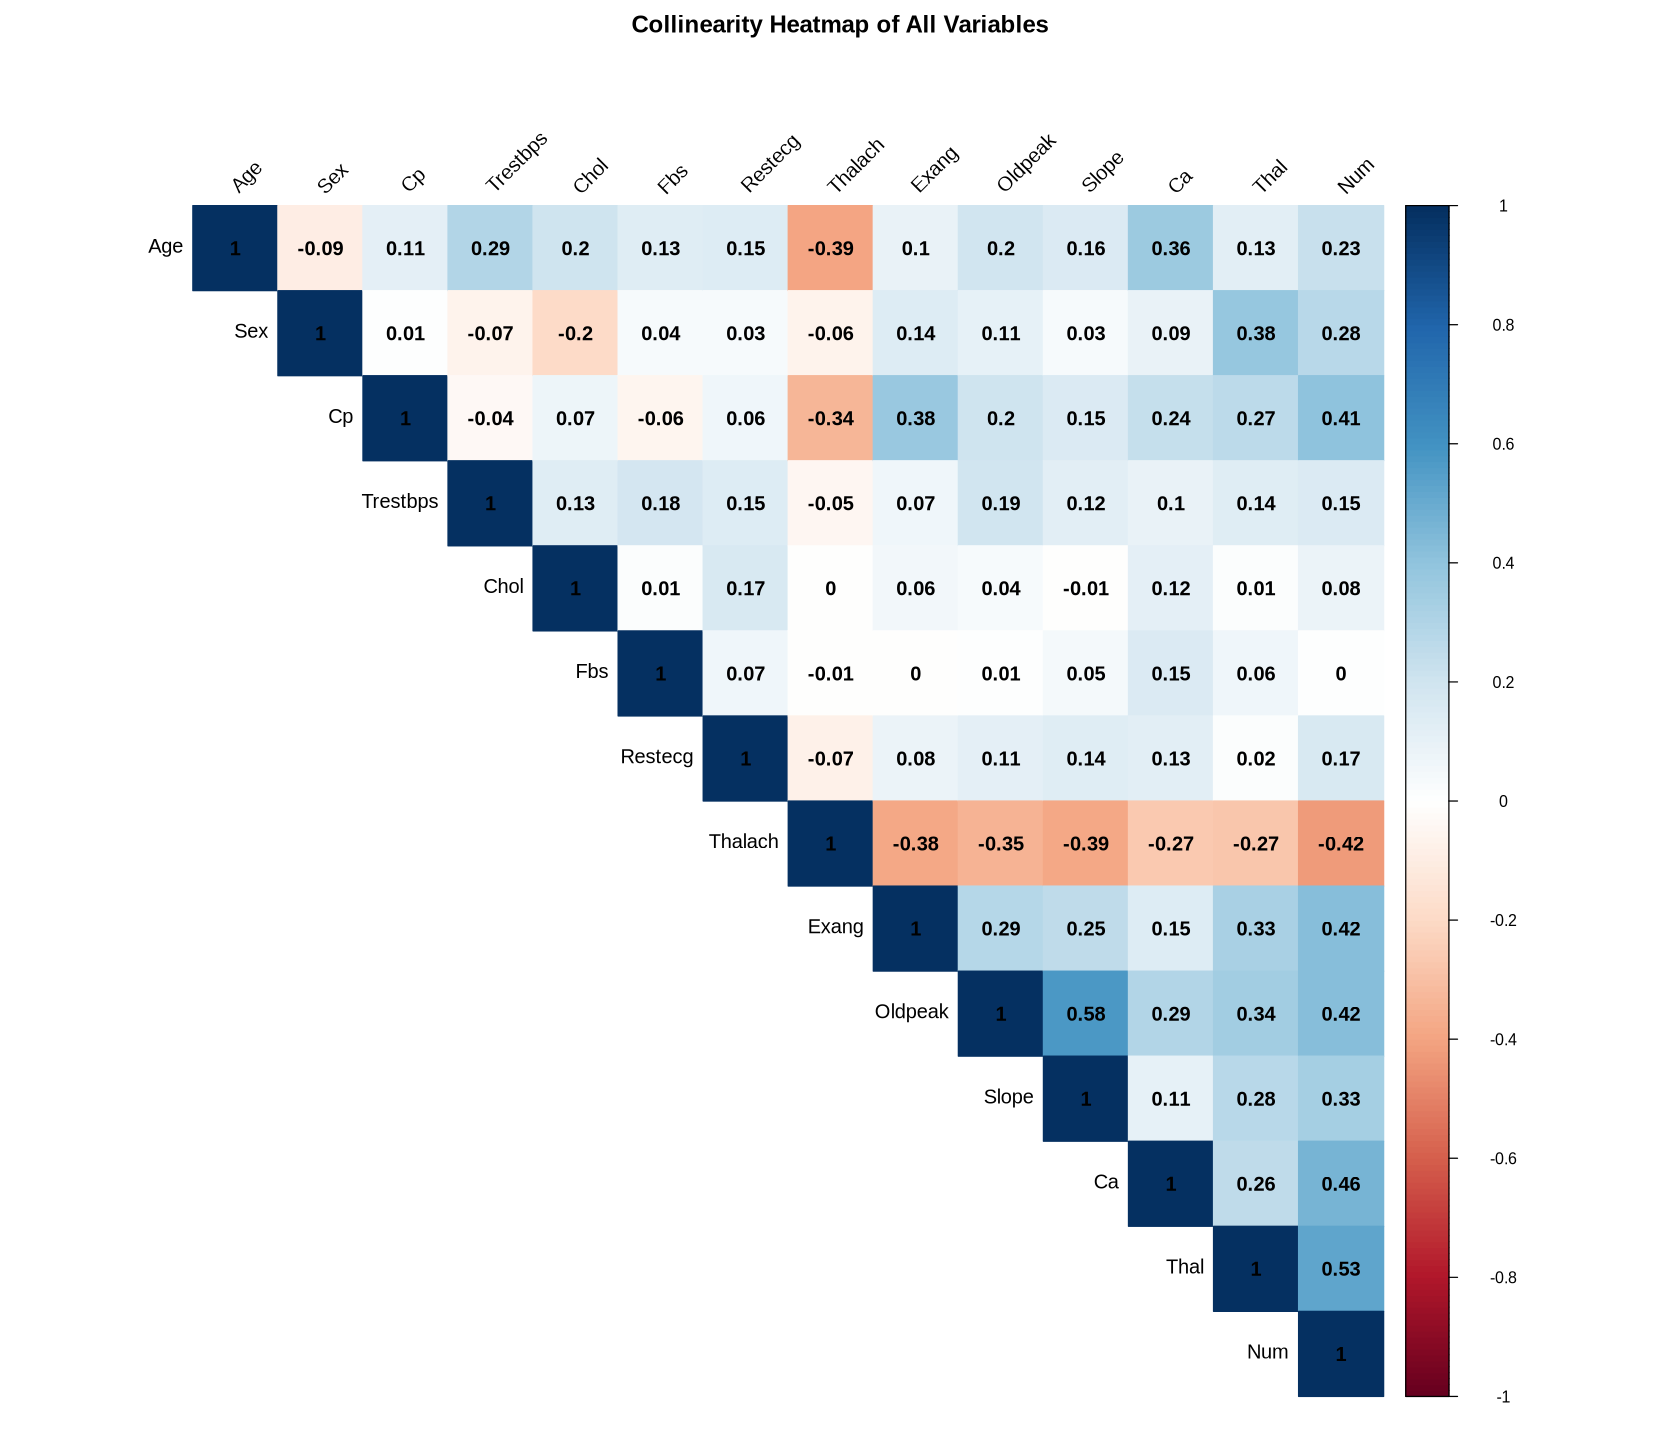

In [17]:
options(repr.plot.width = 14, repr.plot.height = 12) 

correlation_matrix <- data |>
  select(where(is.numeric)) |>
  cor()

par(mar = c(1, 1, 4, 1))  
corrplot(correlation_matrix, method = "color", type = "upper",
         tl.col = "black", tl.srt = 45, addCoef.col = "black",
         title = "Collinearity Heatmap of All Variables", 
         mar = c(0, 0, 2, 0))

 - oldpeak and slope have really high correlation as shown in the plot

#### Boxplot (Numerical vs Response)

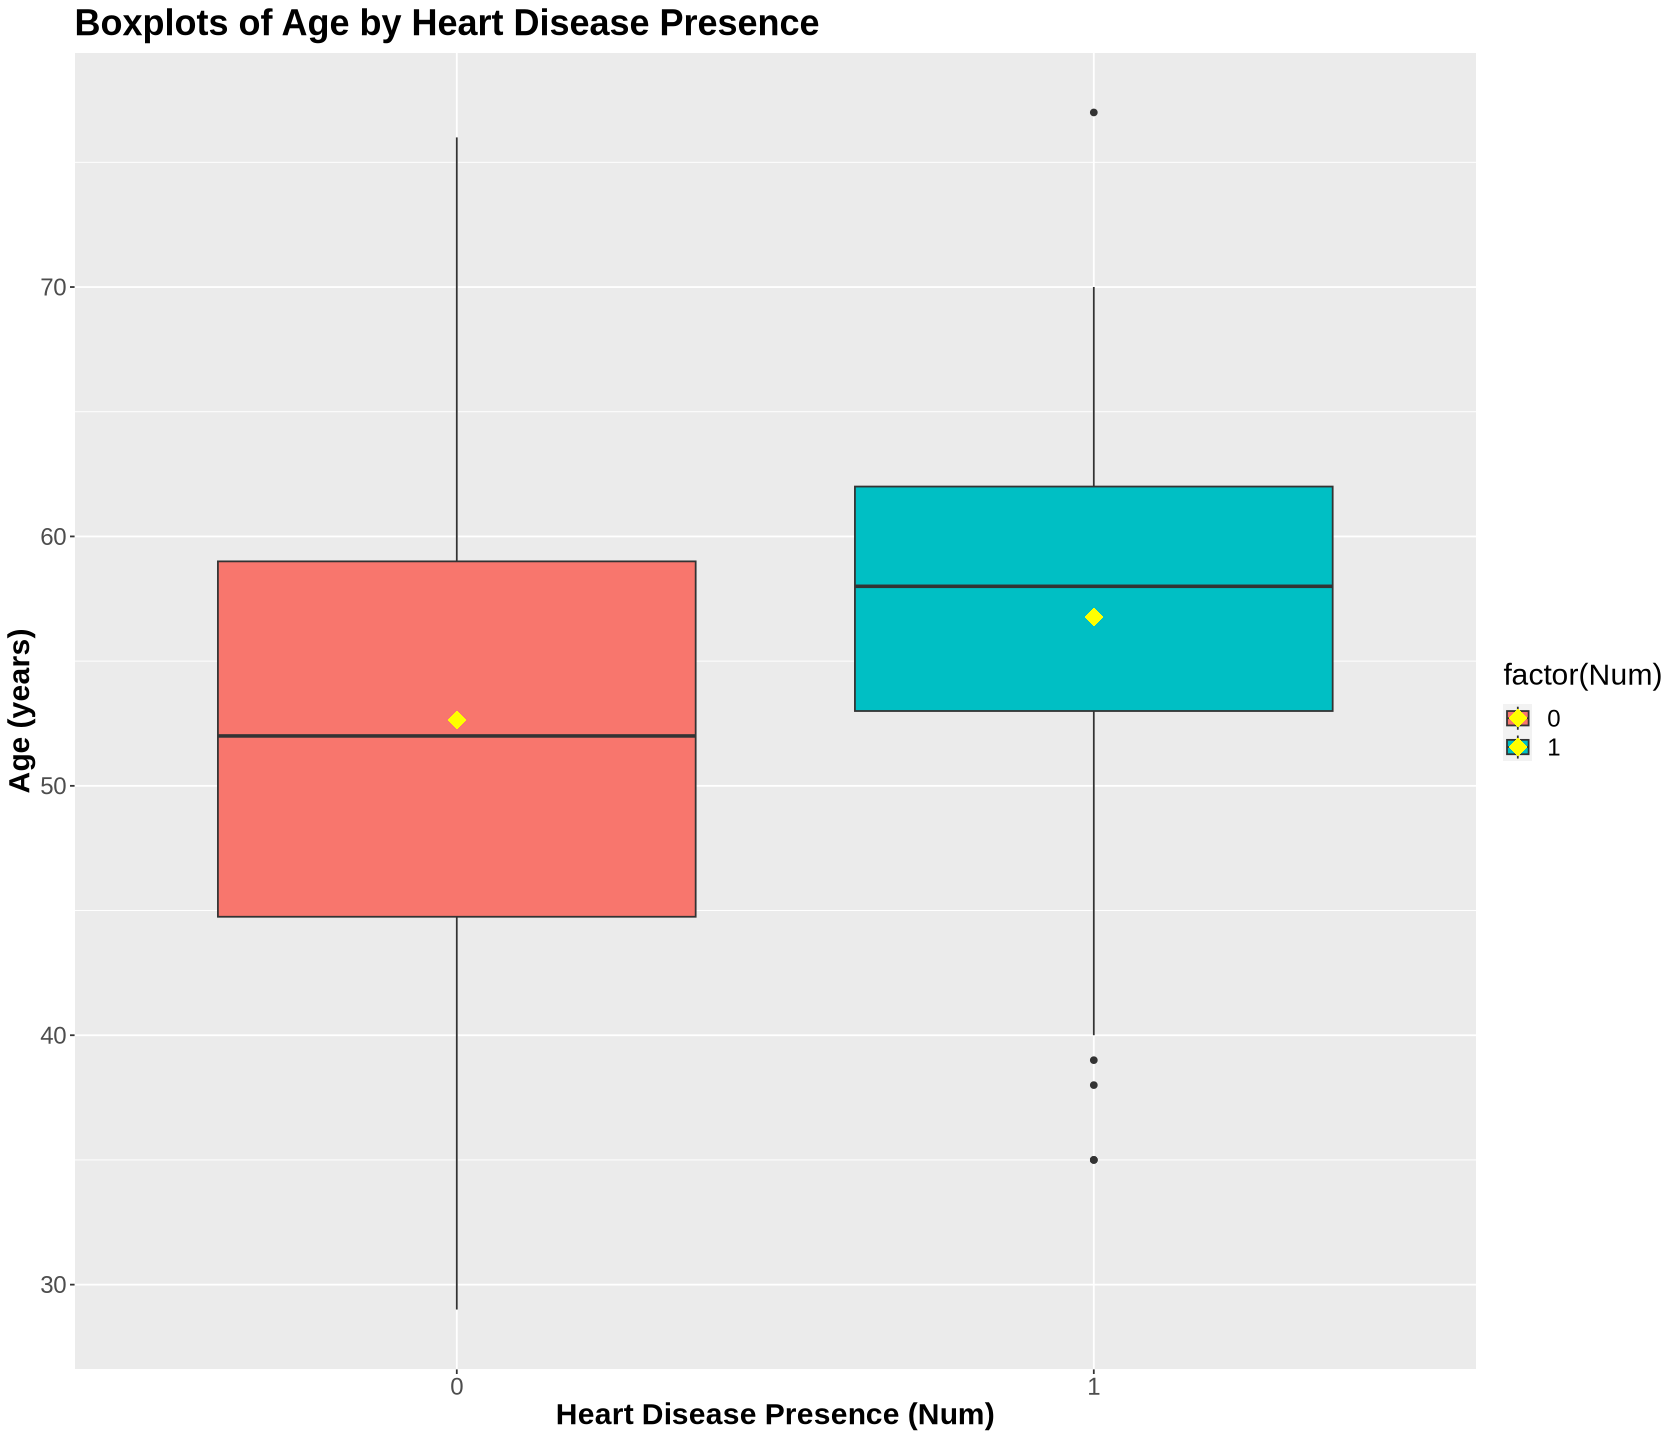

In [18]:
plot_Age <- 
    data |>
    ggplot(aes(x = factor(Num), y = Age, fill = factor(Num))) +
    geom_boxplot() +
    ggtitle("Boxplots of Age by Heart Disease Presence") +
    xlab("Heart Disease Presence (Num)") +
    ylab("Age (years)") +
    stat_summary(
      aes(x = factor(Num), y = Age),
      fun = mean, geom = "point", color = 'yellow',
      shape = 18, size = 5
    ) +
    theme(
        text = element_text(size = 18),
        plot.title = element_text(face = "bold"),
        axis.title = element_text(face = "bold")
    )

plot_Age


The presence of the heart disease is higher in the age group over 50 and the smallest of heart disease is at 35 which is very young

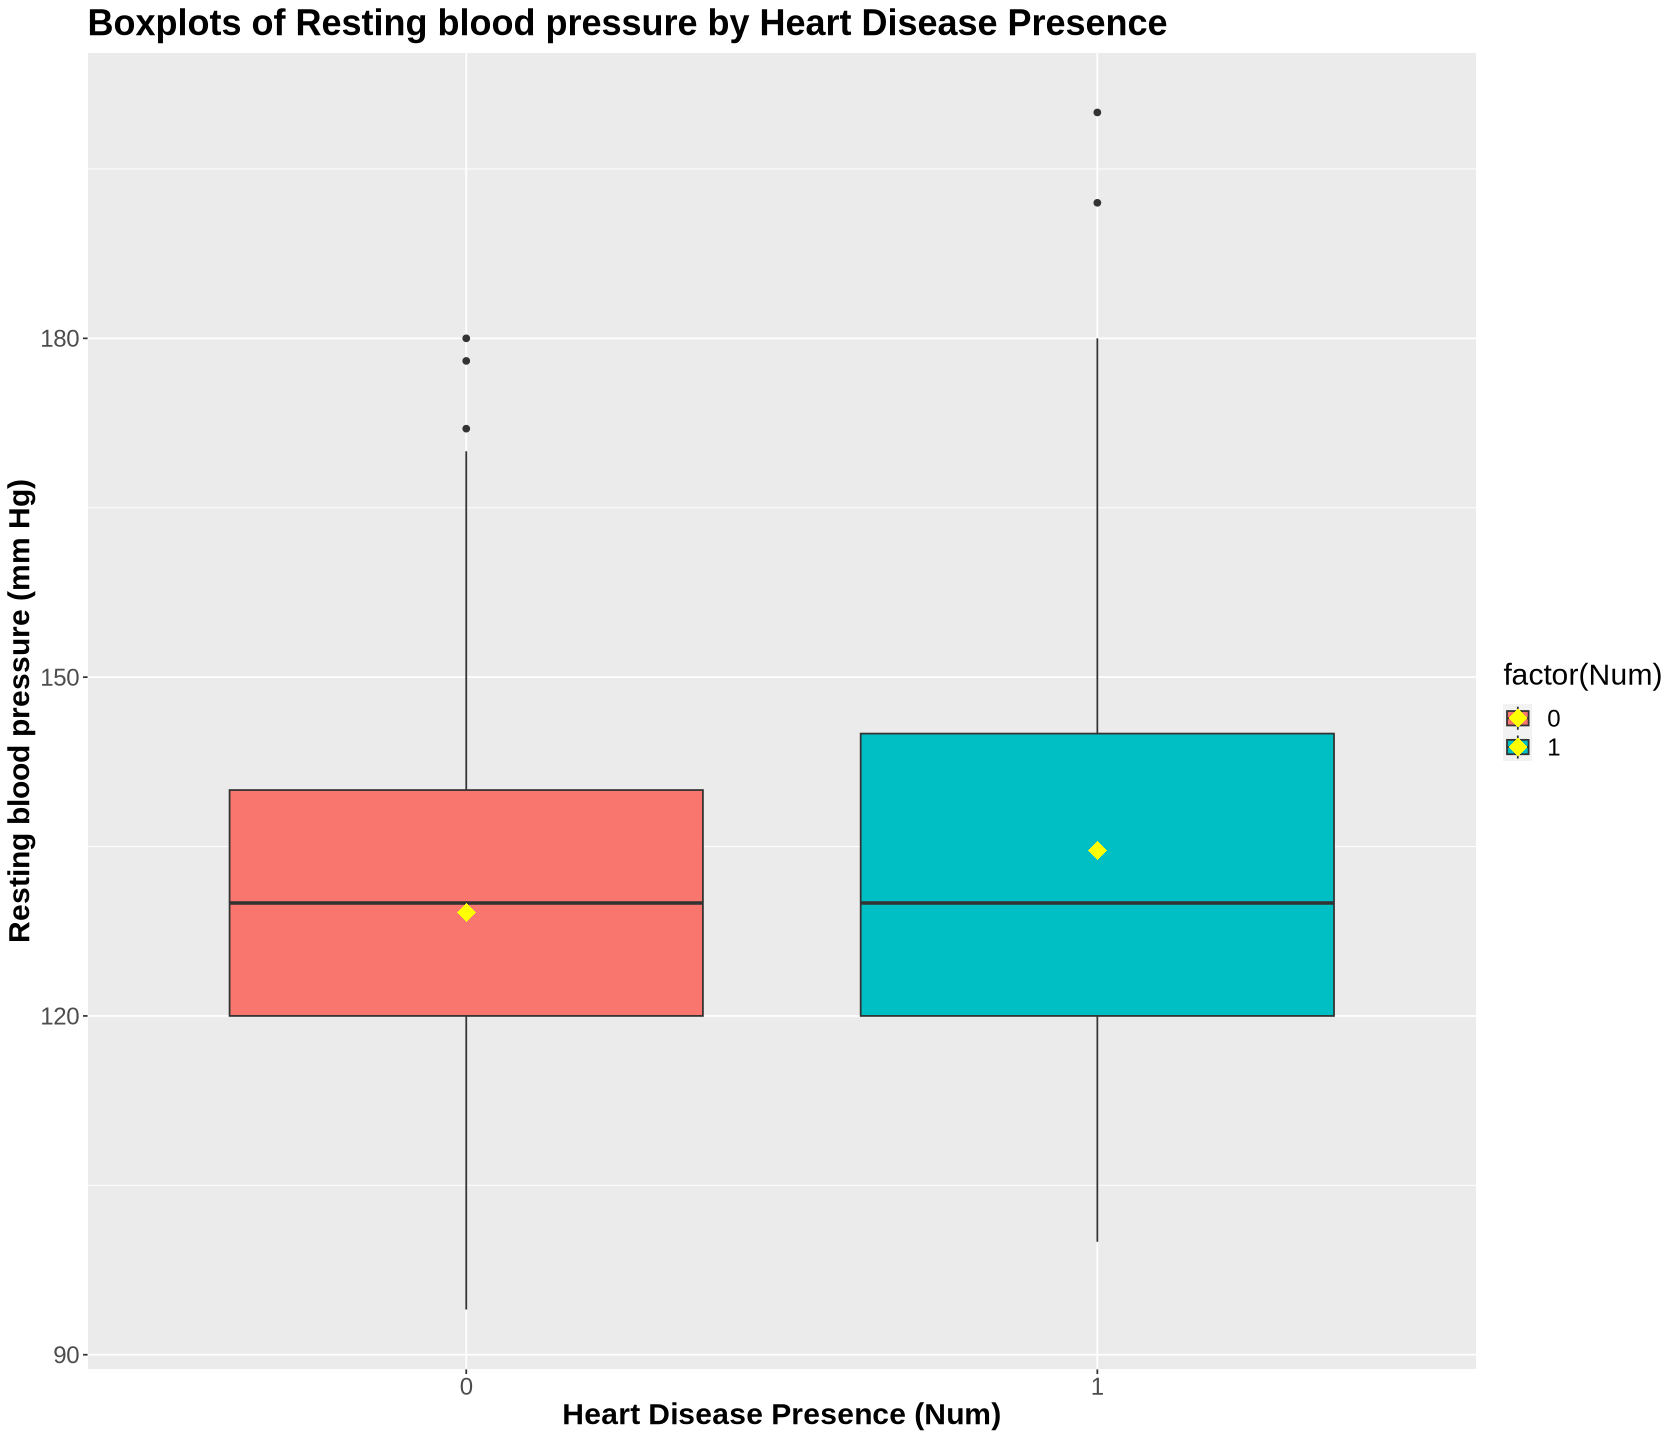

In [19]:
plot_Trestbps  <- 
    data |>
    ggplot(aes(x = factor(Num), y = Trestbps, fill = factor(Num))) +
    geom_boxplot() +
    ggtitle("Boxplots of Resting blood pressure by Heart Disease Presence") +
    xlab("Heart Disease Presence (Num)") +
    ylab("Resting blood pressure (mm Hg)") +
    stat_summary(
      aes(x = factor(Num), y = Trestbps),
      fun = mean, geom = "point", color = 'yellow',
      shape = 18, size = 5
    ) +
    theme(
        text = element_text(size = 18),
        plot.title = element_text(face = "bold"),
        axis.title = element_text(face = "bold")
    )
plot_Trestbps

There is not a lot of difference in the two groups, though the upper percentile of the group with heart disease is higher then group with no heart disease

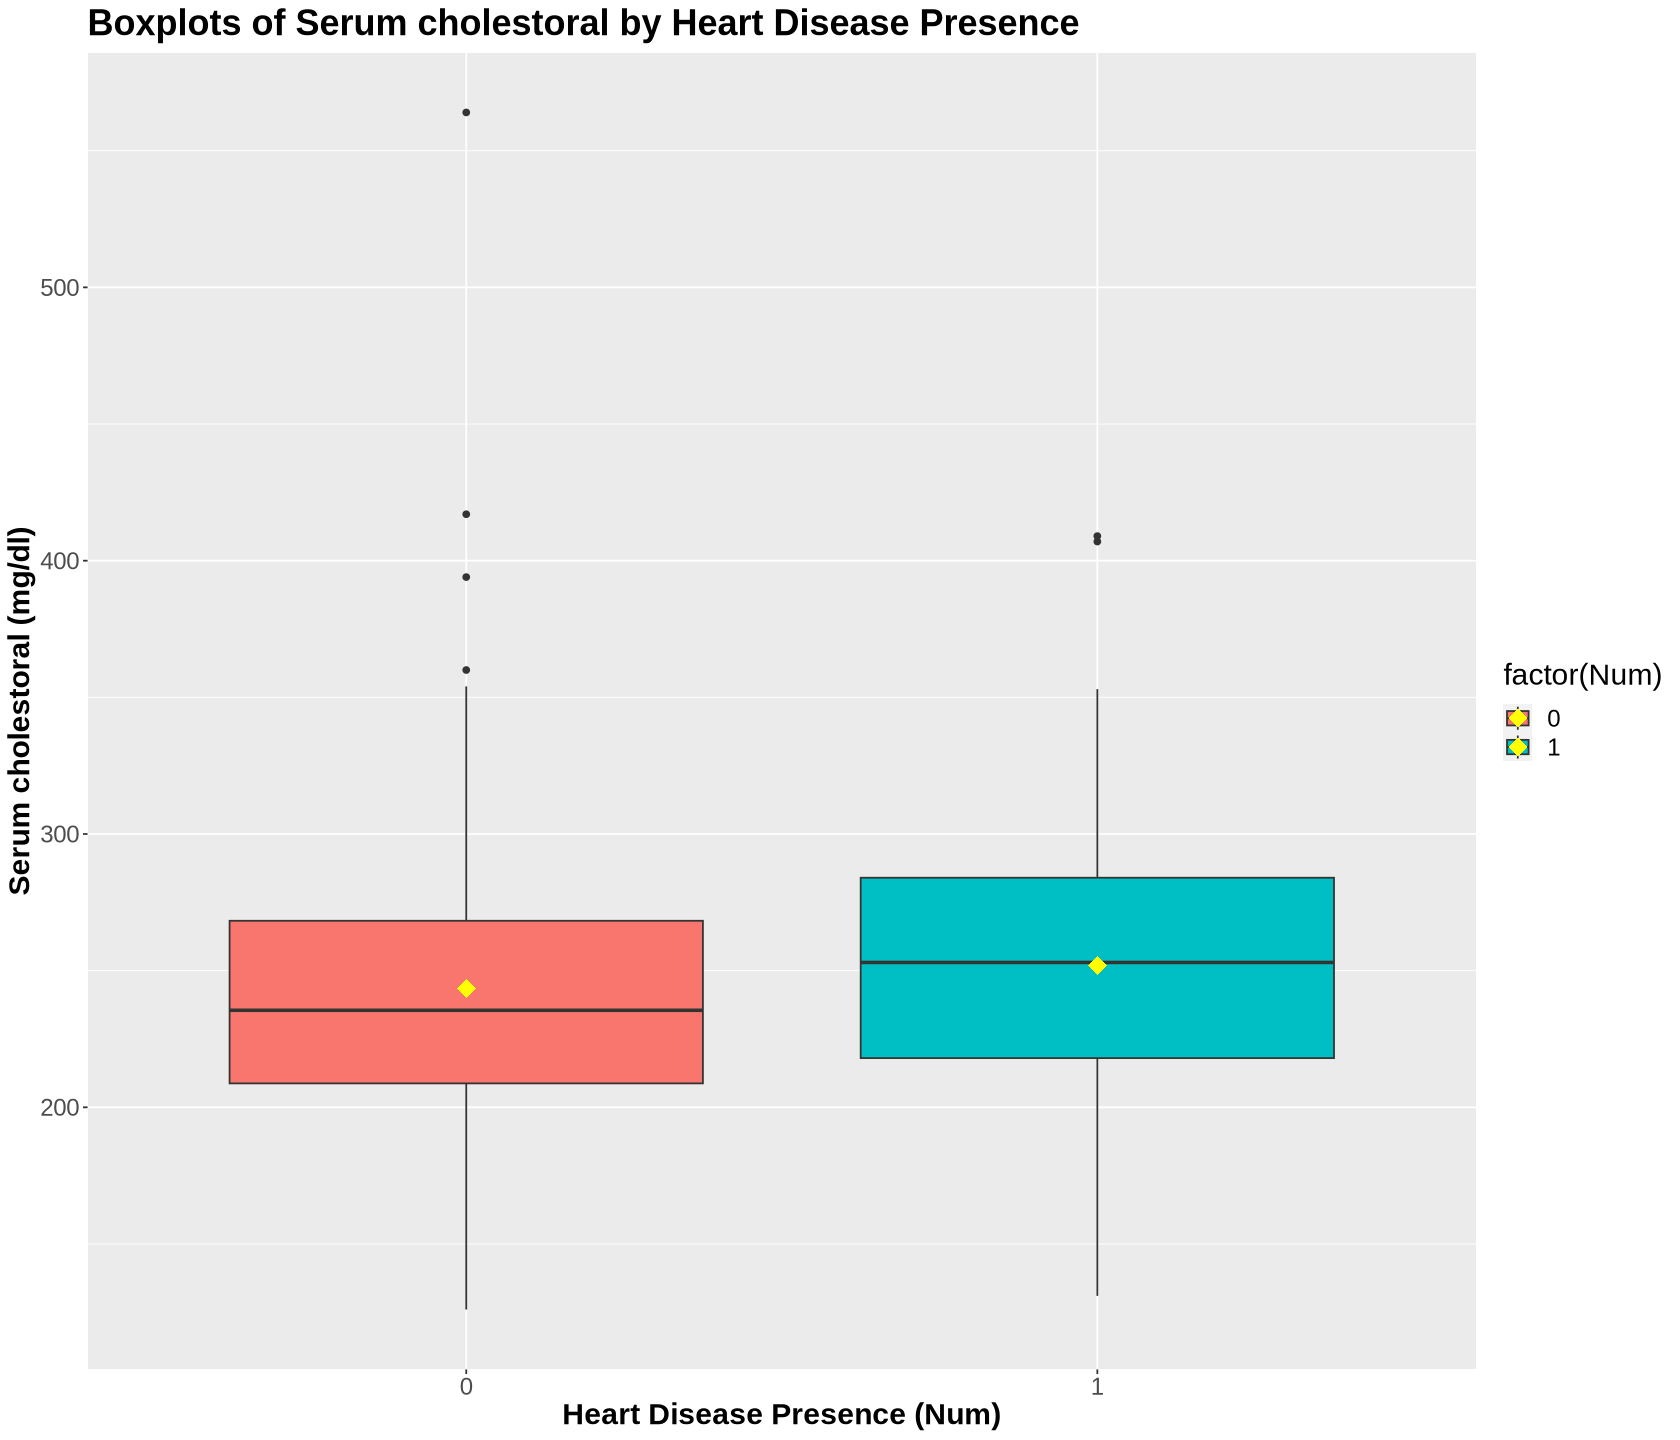

In [20]:
plot_Chol  <- 
    data |>
    ggplot(aes(x = factor(Num), y = Chol, fill = factor(Num))) +
    geom_boxplot() +
    ggtitle("Boxplots of Serum cholestoral by Heart Disease Presence") +
    xlab("Heart Disease Presence (Num)") +
    ylab("Serum cholestoral (mg/dl)") +
    stat_summary(
      aes(x = factor(Num), y = Chol),
      fun = mean, geom = "point", color = 'yellow',
      shape = 18, size = 5
    ) +
    theme(
        text = element_text(size = 18),
        plot.title = element_text(face = "bold"),
        axis.title = element_text(face = "bold")
    )

plot_Chol

There presence of heart disease is slightly higher in high cholestoral but even with average levels of cholestoral there is still presence of heart disease

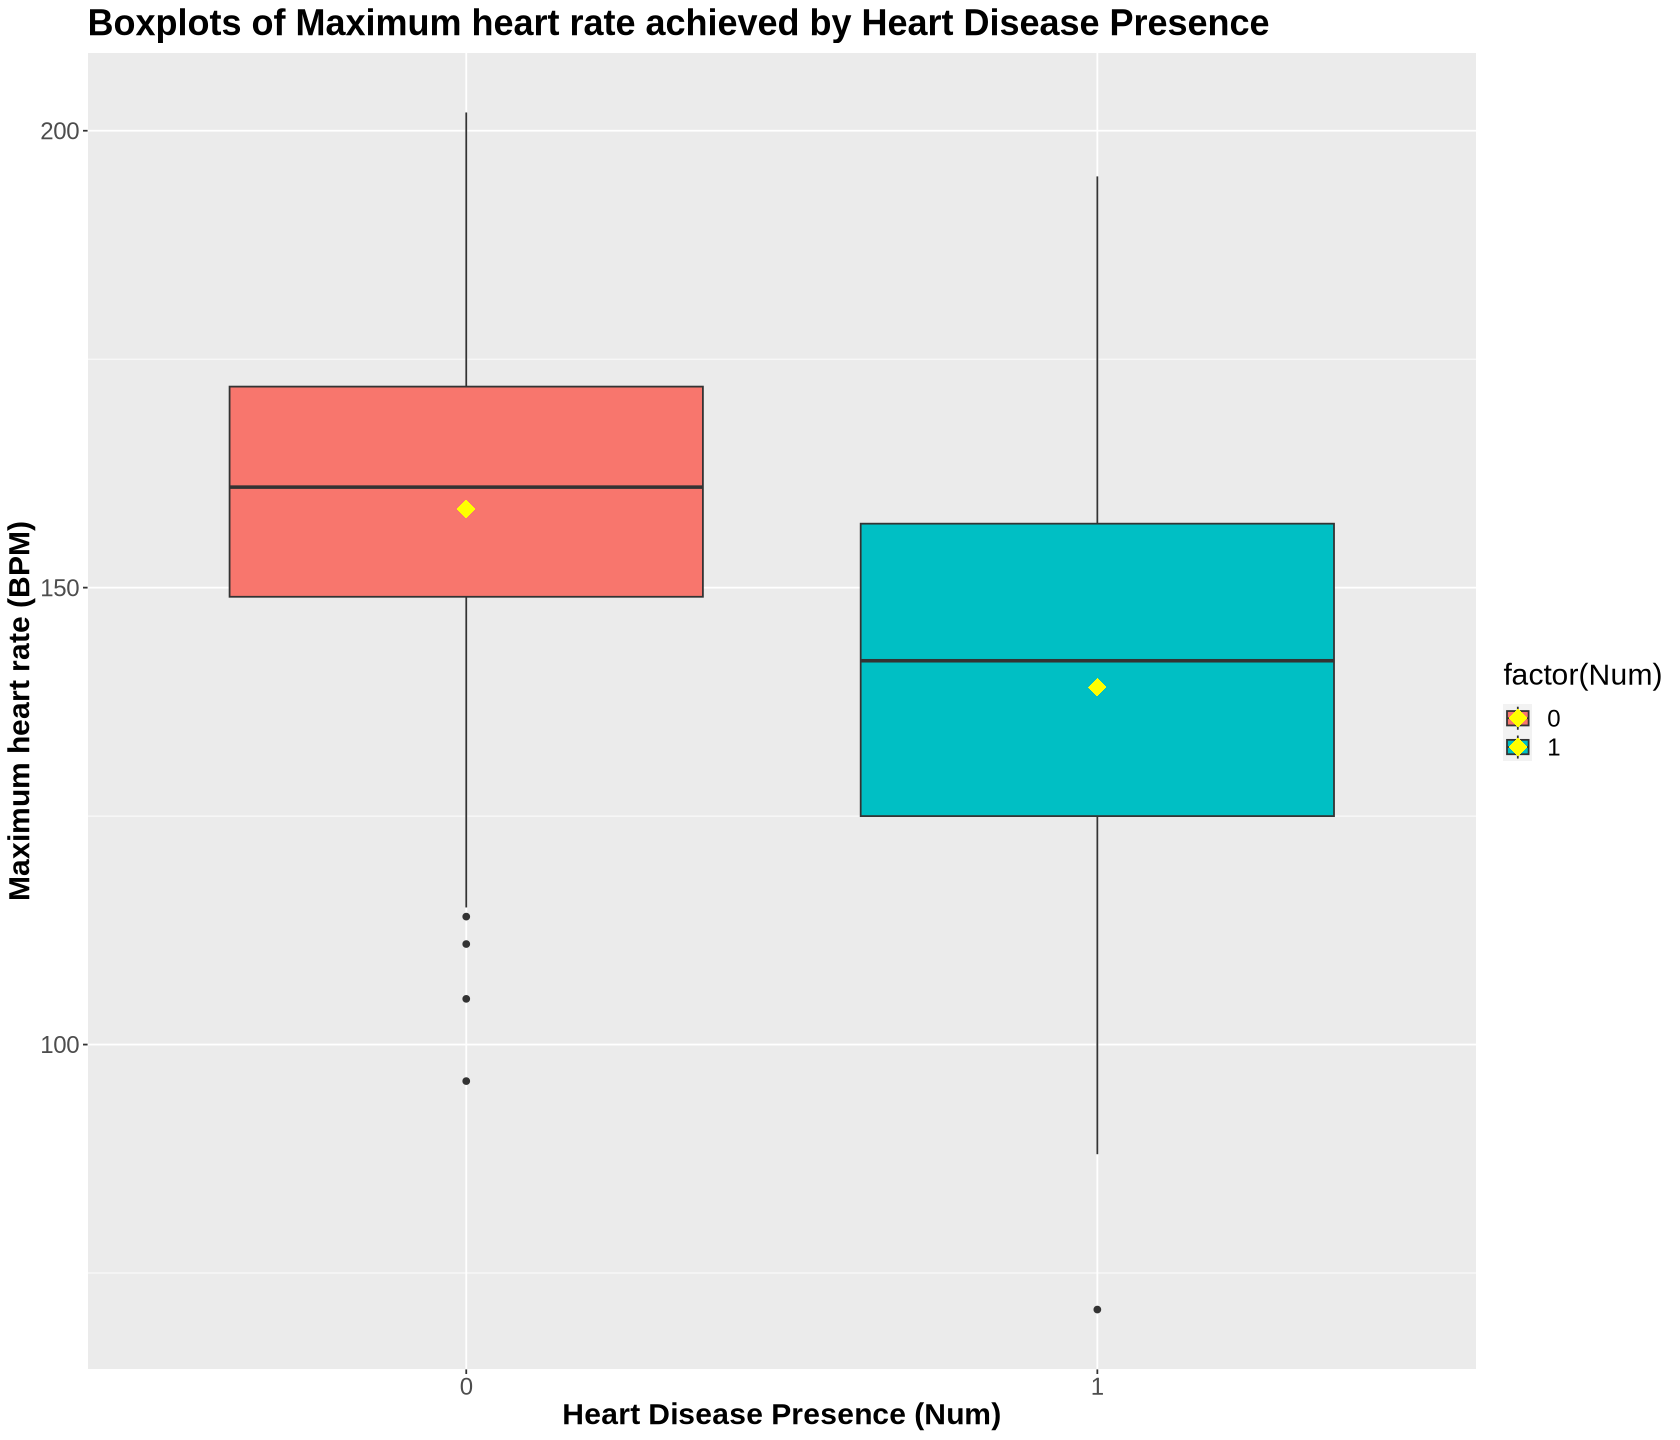

In [21]:
plot_Thalach  <- 
    data |>
    ggplot(aes(x = factor(Num), y = Thalach, fill = factor(Num))) +
    geom_boxplot() +
    ggtitle("Boxplots of Maximum heart rate achieved by Heart Disease Presence") +
    xlab("Heart Disease Presence (Num)") +
    ylab("Maximum heart rate (BPM)") +
    stat_summary(
      aes(x = factor(Num), y = Thalach),
      fun = mean, geom = "point", color = 'yellow',
      shape = 18, size = 5
    ) +
    theme(
        text = element_text(size = 18),
        plot.title = element_text(face = "bold"),
        axis.title = element_text(face = "bold")
    )

plot_Thalach

The presence of heart disease is a lot lower in the group that have higher maximum heart disease

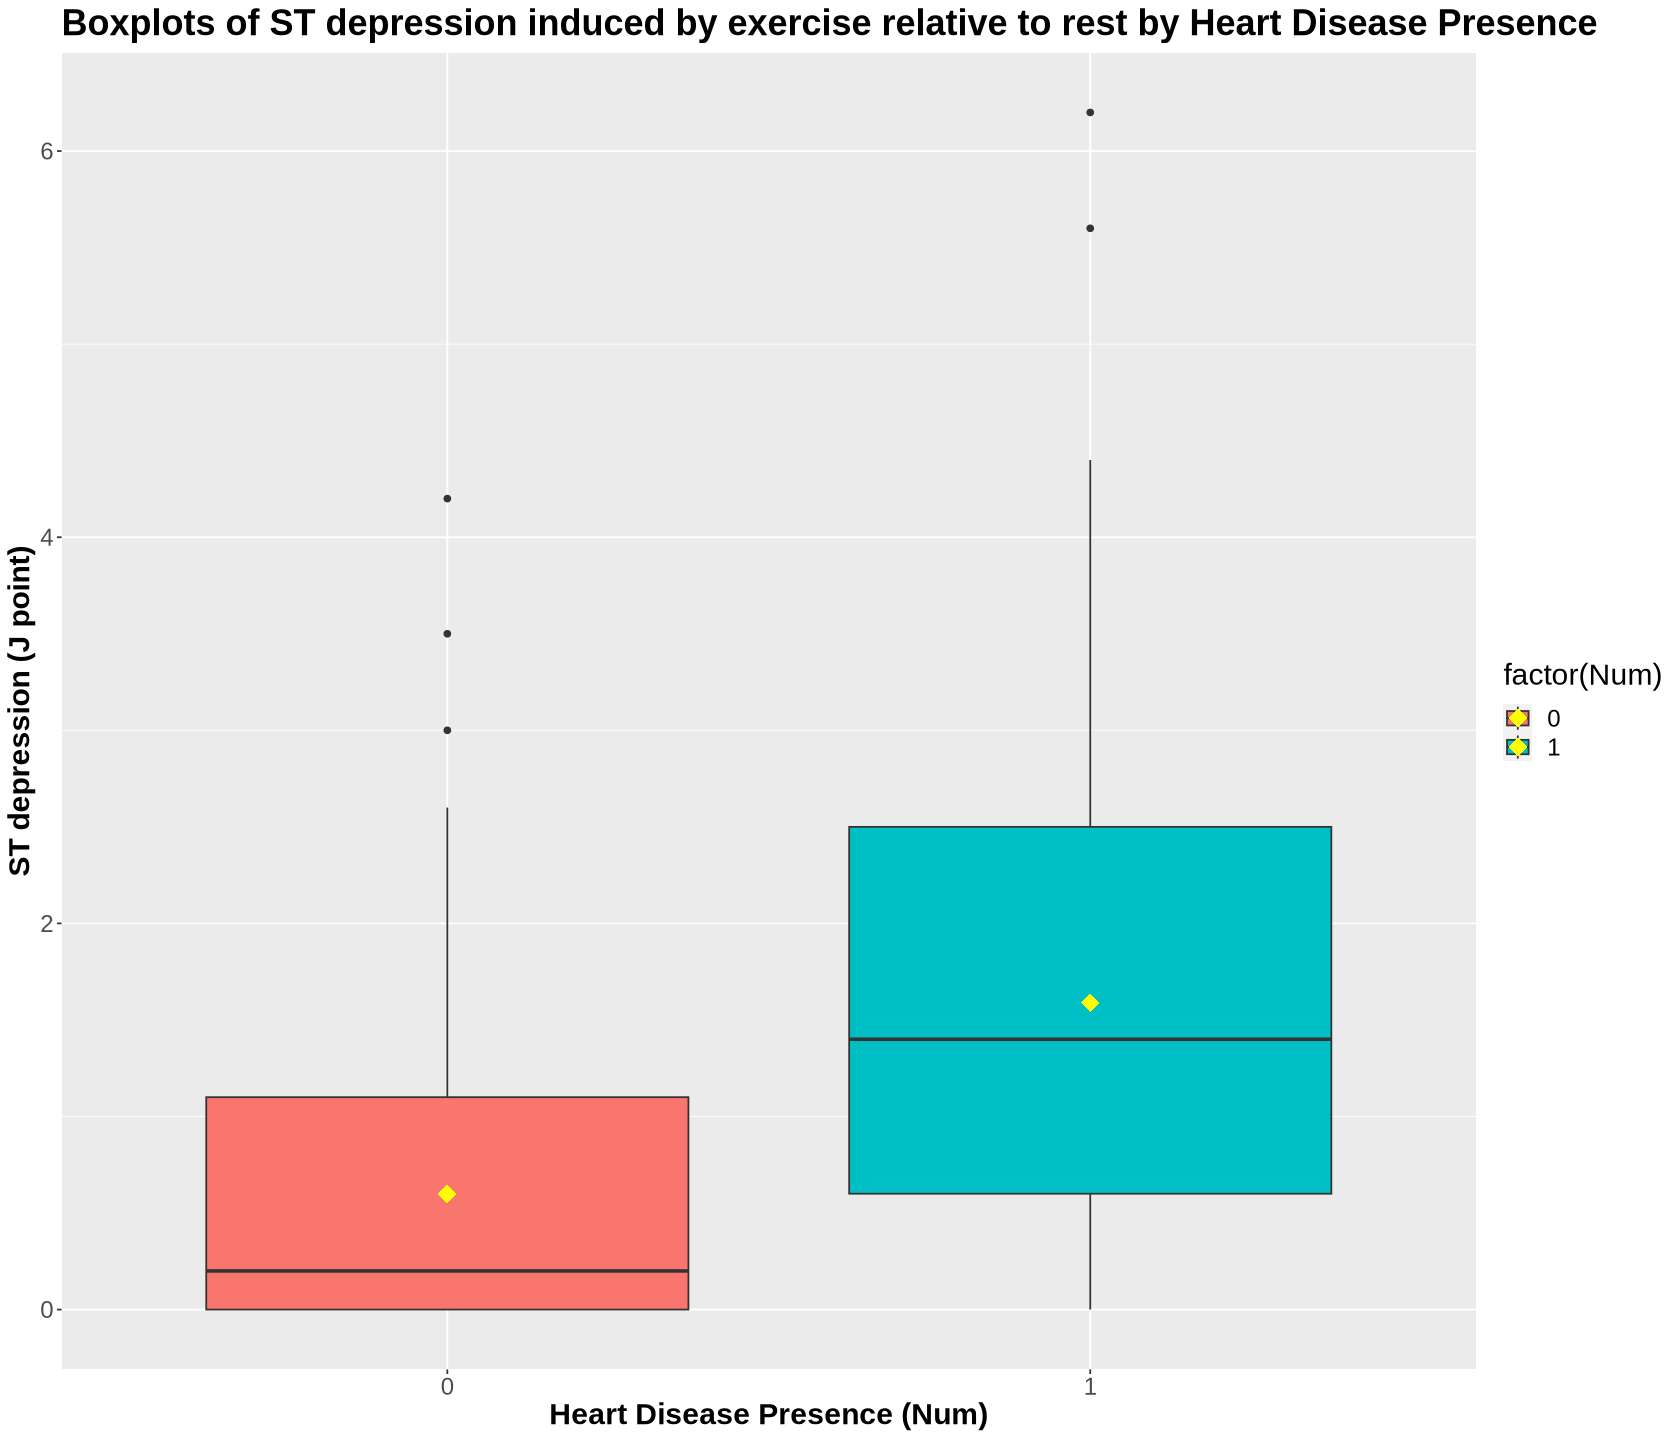

In [22]:
plot_Oldpeak  <- 
    data |>
    ggplot(aes(x = factor(Num), y = Oldpeak, fill = factor(Num))) +
    geom_boxplot() +
    ggtitle("Boxplots of ST depression induced by exercise relative to rest by Heart Disease Presence") +
    xlab("Heart Disease Presence (Num)") +
    ylab("ST depression (J point)") +
    stat_summary(
      aes(x = factor(Num), y = Oldpeak),
      fun = mean, geom = "point", color = 'yellow',
      shape = 18, size = 5
    ) +
    theme(
        text = element_text(size = 18),
        plot.title = element_text(face = "bold"),
        axis.title = element_text(face = "bold")
    )

plot_Oldpeak

There is a significant difference between the two groups which the group with presence of heart disease have the higher ST depression, and the other group is a lot lower and skewed

#### Mosiac plot

    Sex   0   1
Num            
0        71  89
1        25 112

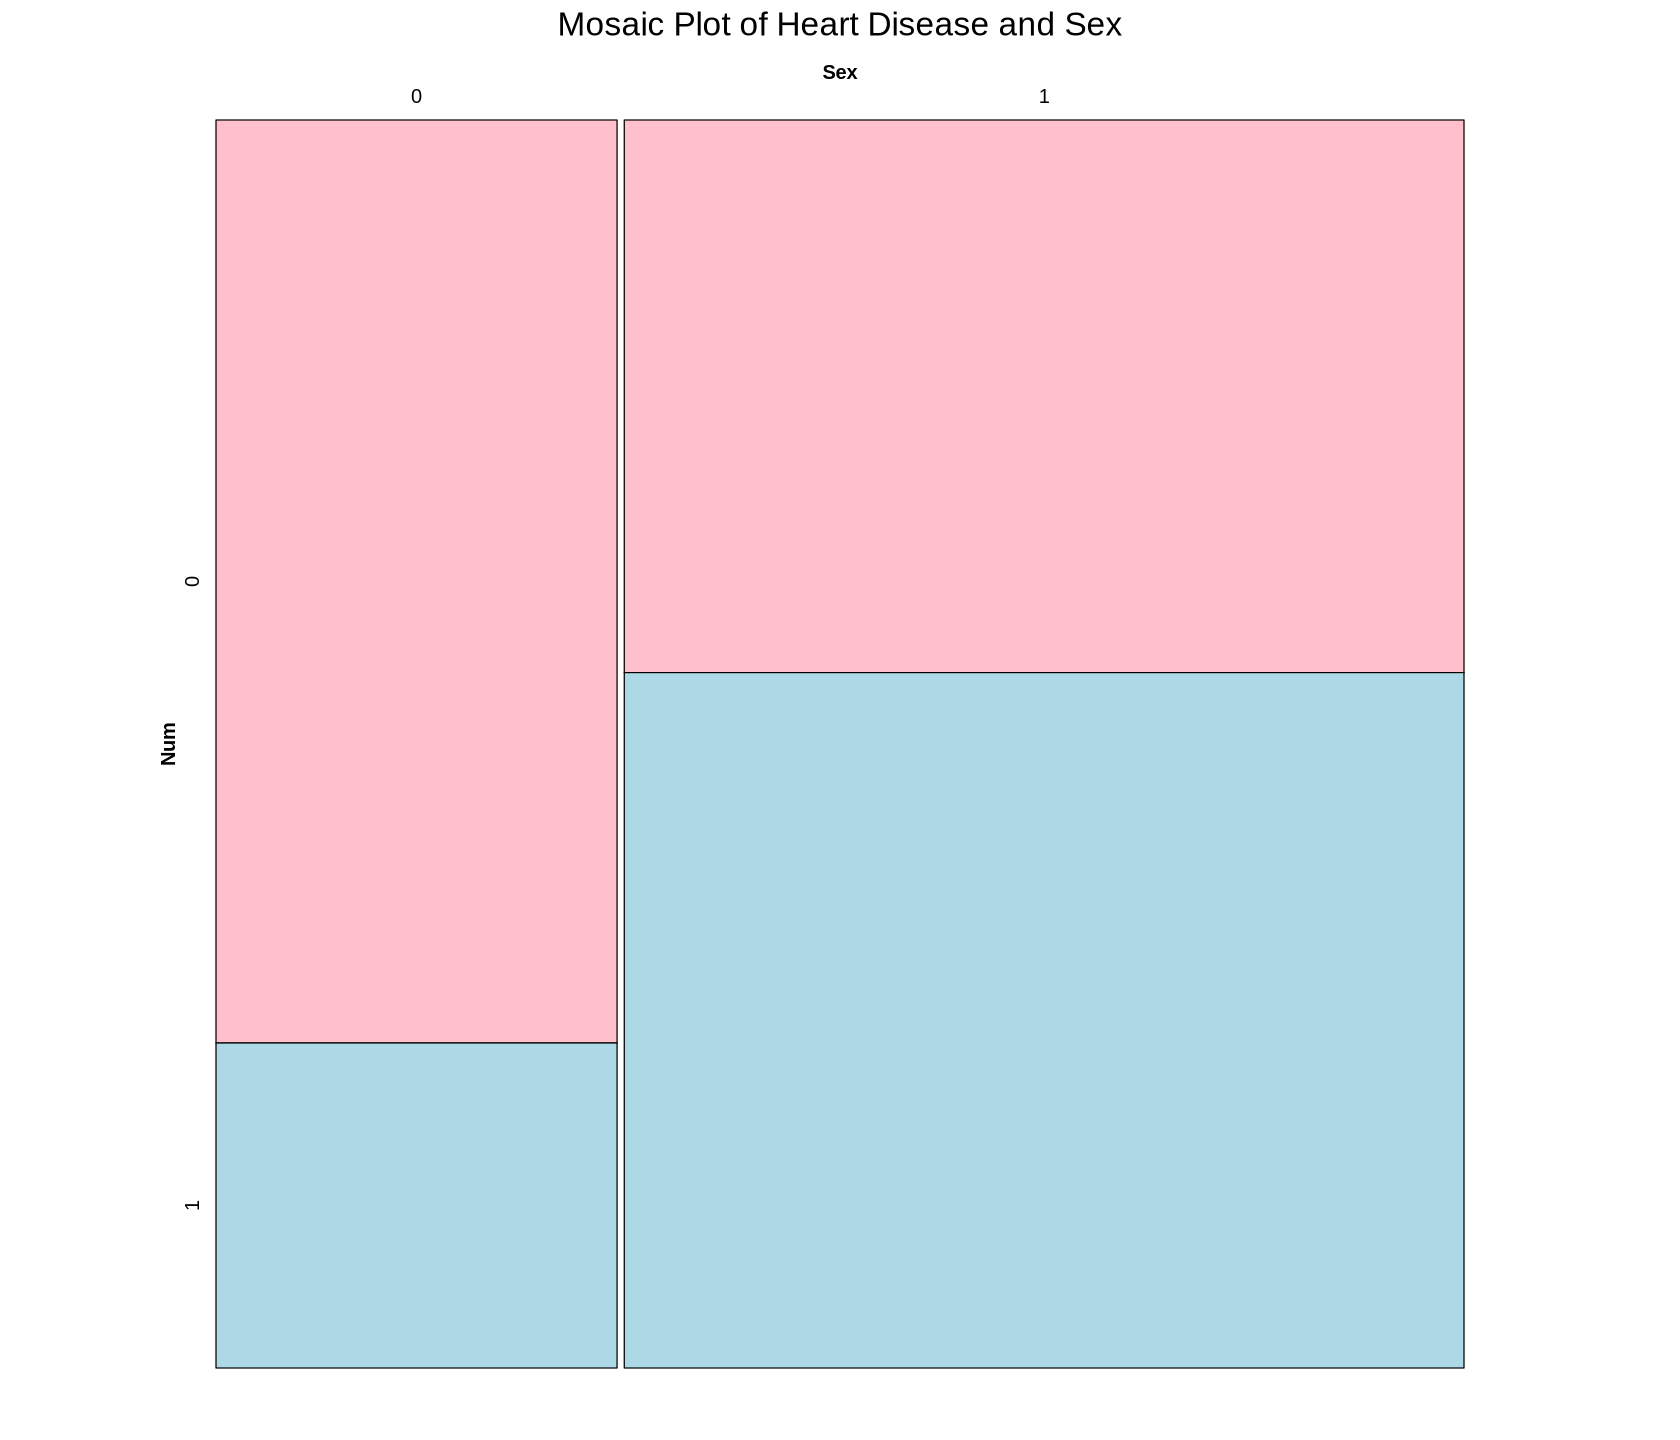

In [23]:


Mosaic_plot_Sex <- mosaic( ~ Num + Sex , data = data, highlighting = "Num", highlighting_fill = c("pink", "lightblue"), main = "Mosaic Plot of Heart Disease and Sex")
Mosaic_plot_Sex

In the group that have presence of heart disease, it is equal between two sex but in the other group, the number of male do not have heart disease is lower than female

    Sex   0   1
Num            
0        71  89
1        25 112

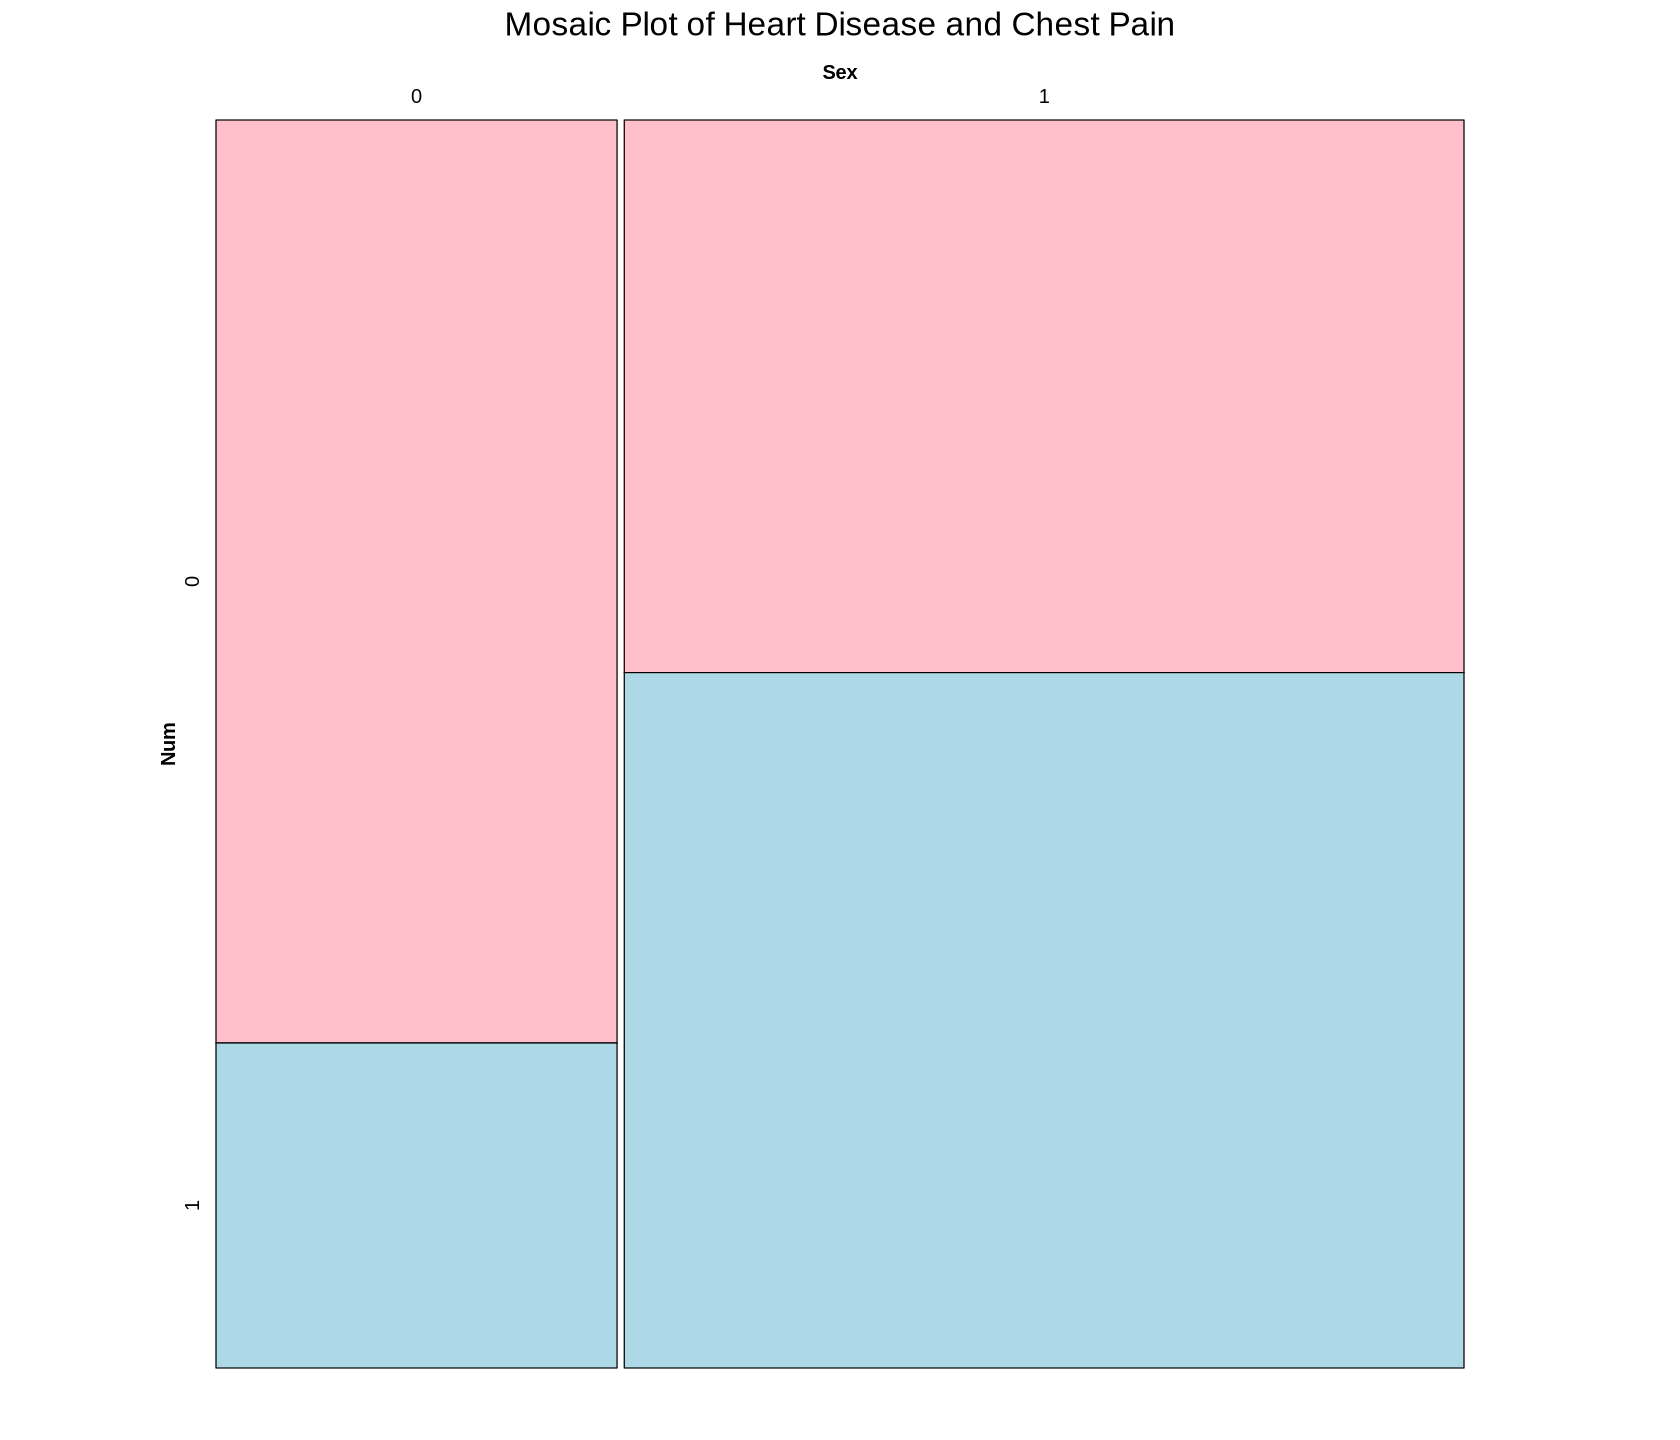

In [24]:
Mosaic_plot_Cp <- mosaic( ~ Num + Sex , data = data, highlighting = "Num", highlighting_fill = c("pink", "lightblue"), main = "Mosaic Plot of Heart Disease and Chest Pain")
Mosaic_plot_Cp

    Fbs   0   1
Num            
0       137  23
1       117  20

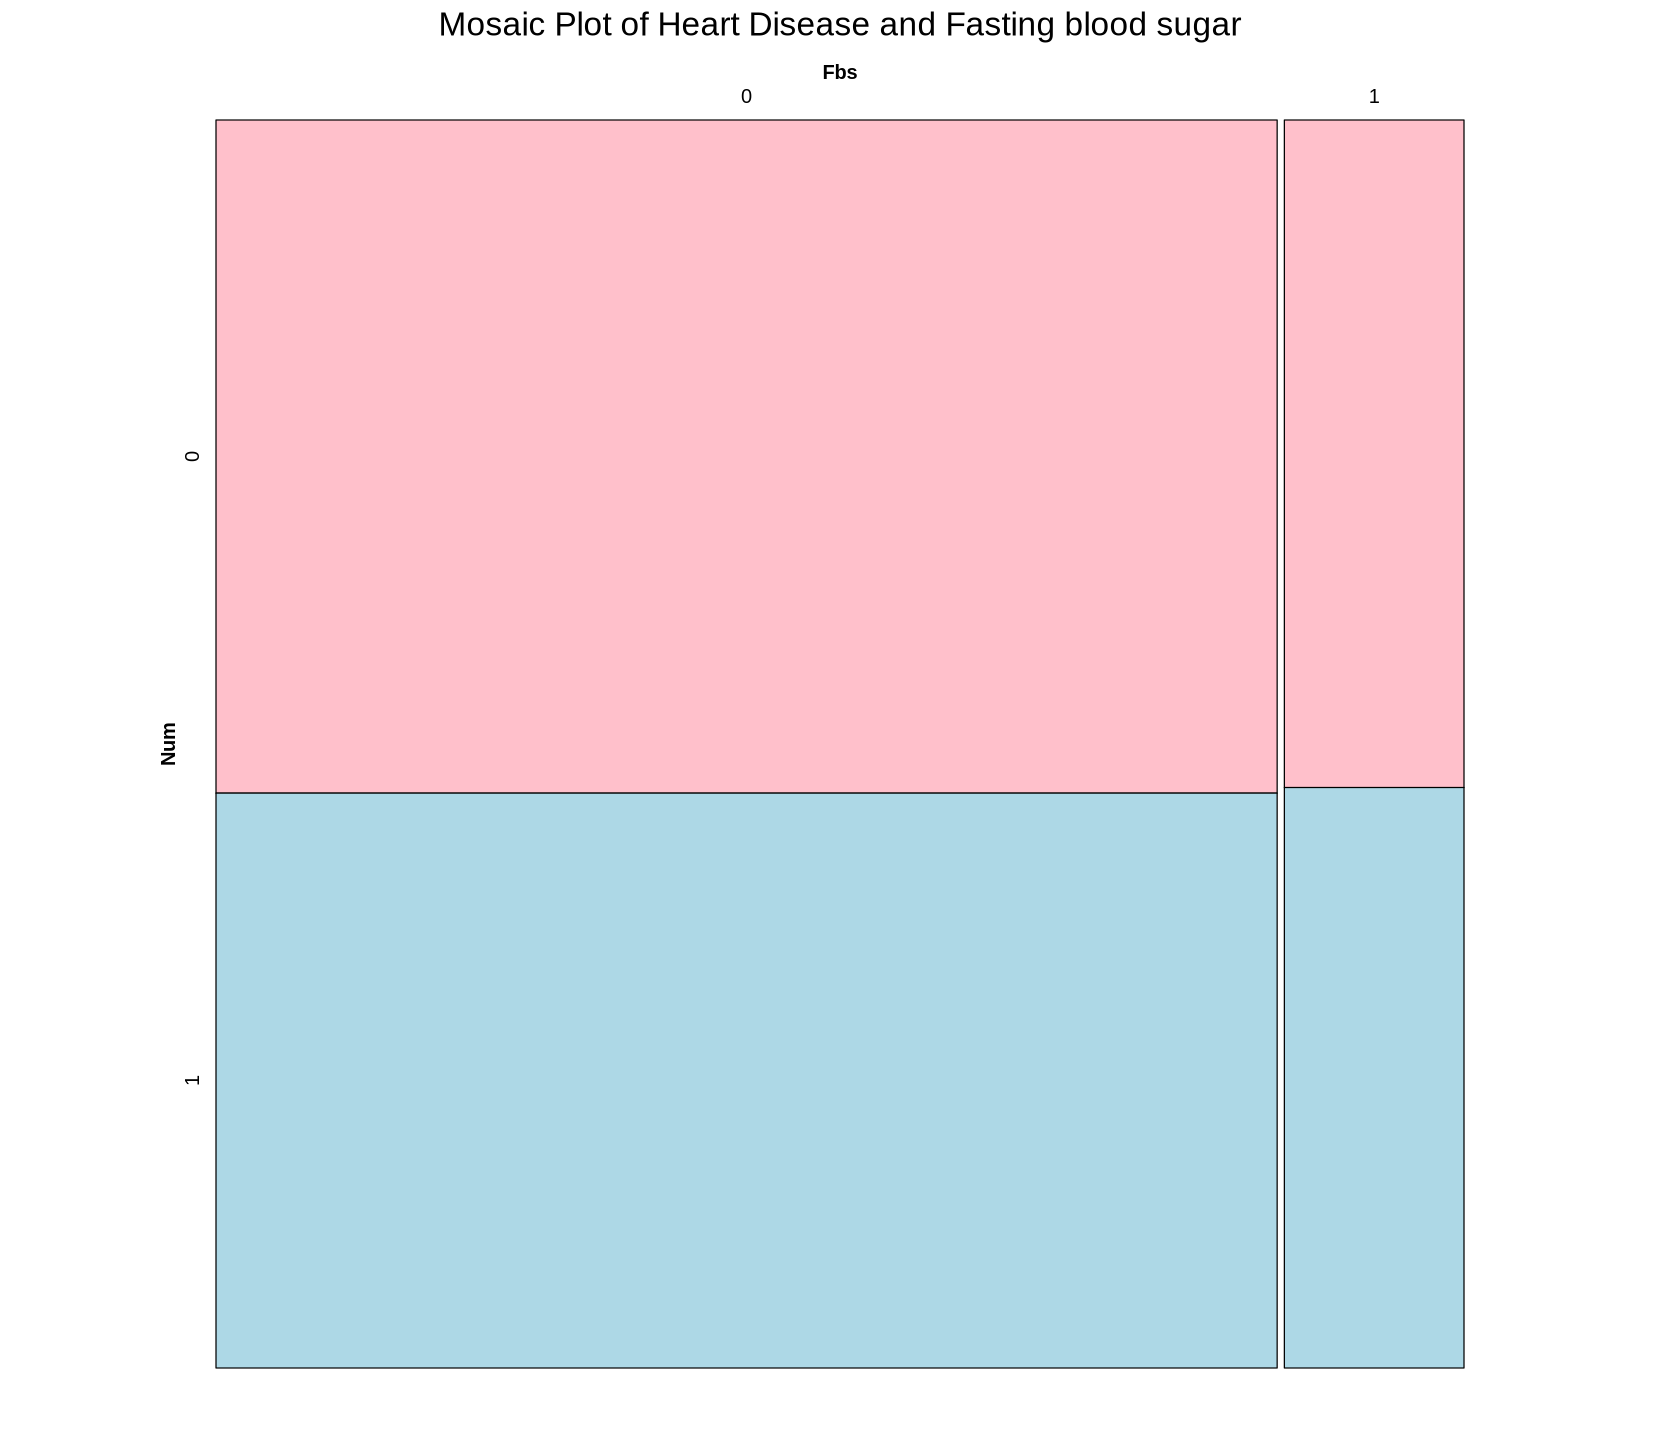

In [25]:
Mosaic_plot_Fbs <- mosaic( ~ Num +Fbs , data = data, highlighting = "Num", highlighting_fill = c("pink", "lightblue"), main = "Mosaic Plot of Heart Disease and Fasting blood sugar")
Mosaic_plot_Fbs

    Restecg  0  1  2
Num                 
0           92  1 67
1           55  3 79

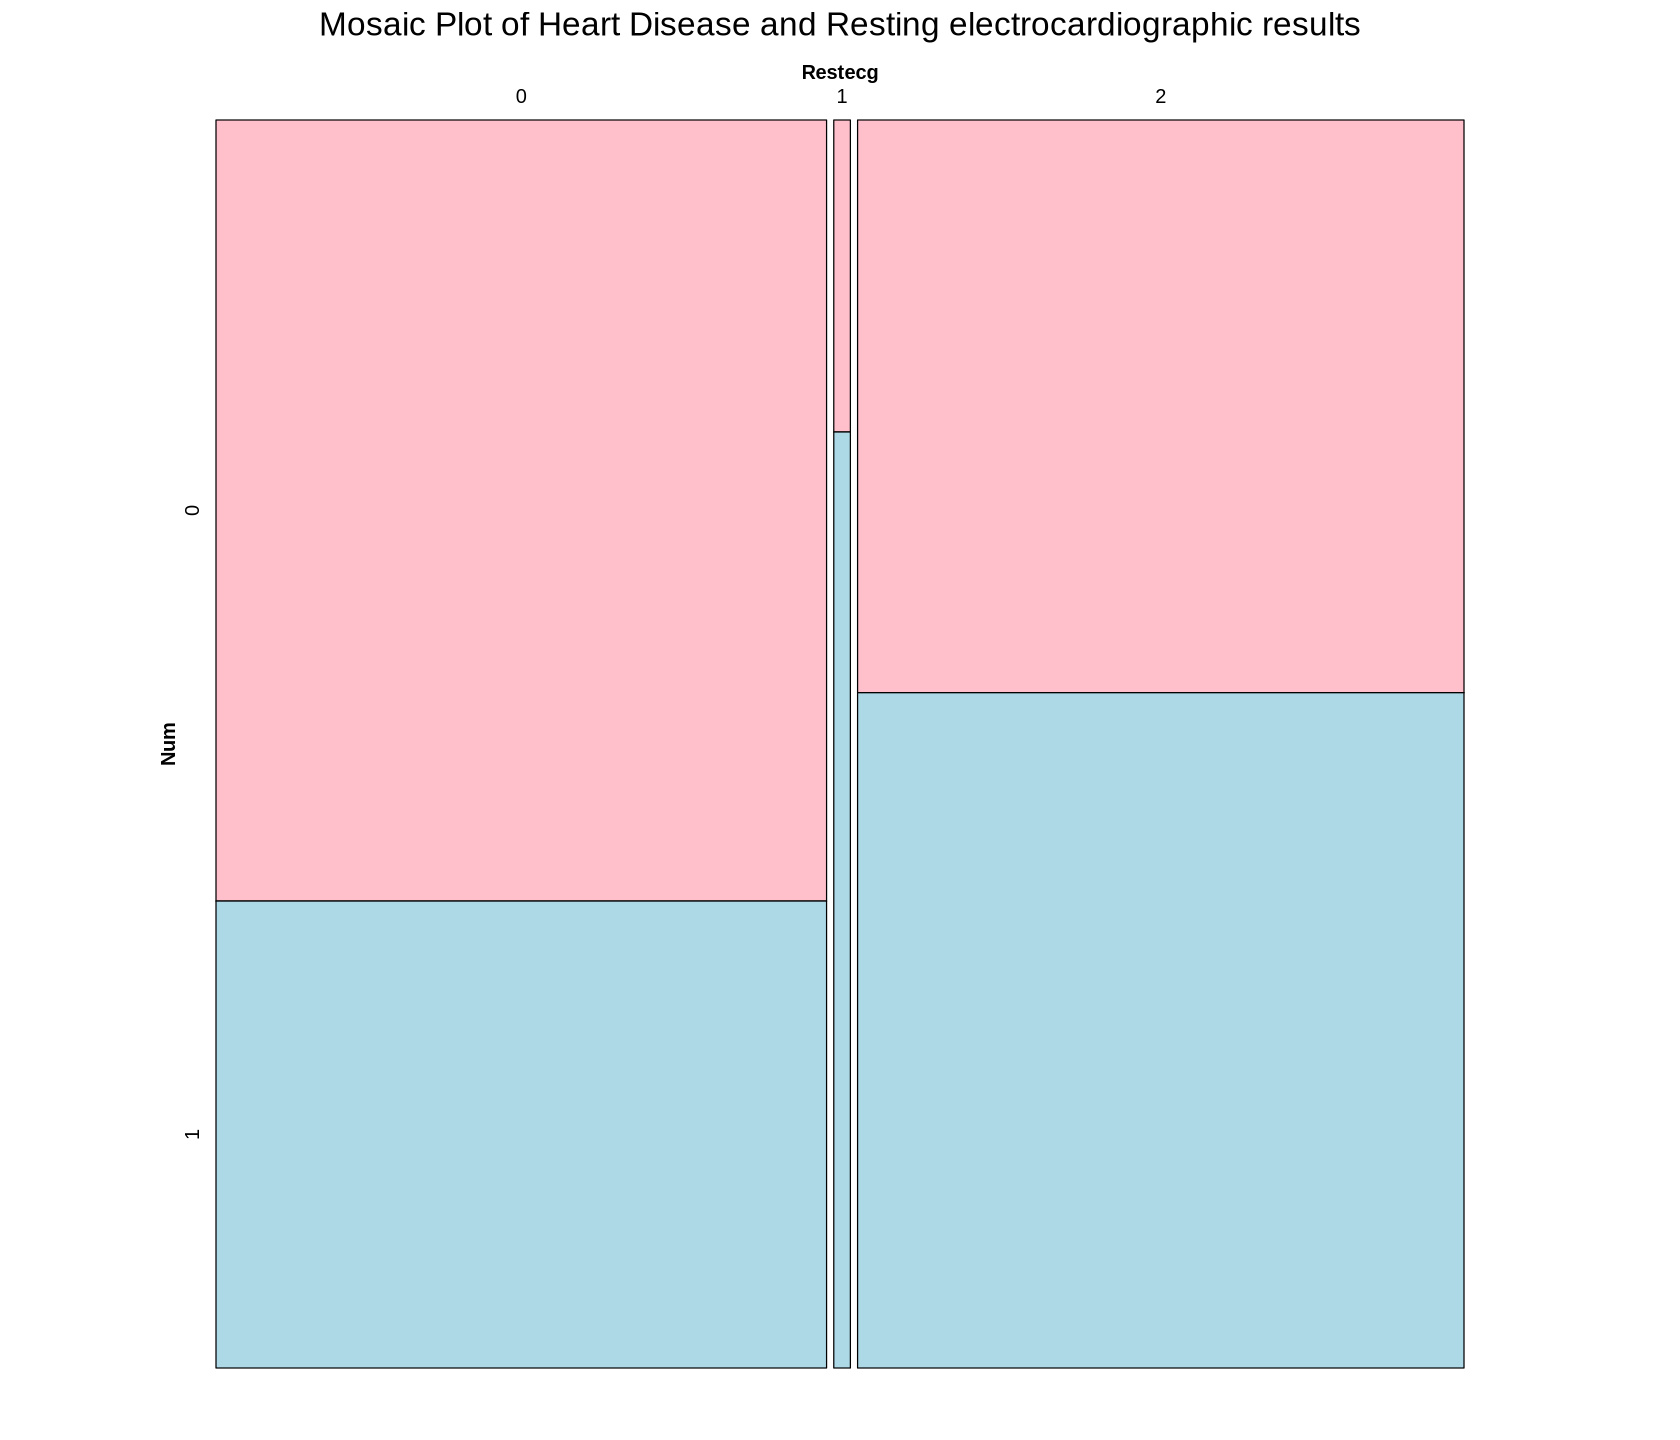

In [26]:
Mosaic_plot_Restecg <- mosaic( ~ Num + Restecg , data = data, highlighting = "Num", highlighting_fill = c("pink", "lightblue"), main = "Mosaic Plot of Heart Disease and Resting electrocardiographic results")
Mosaic_plot_Restecg

    Exang   0   1
Num              
0         137  23
1          63  74

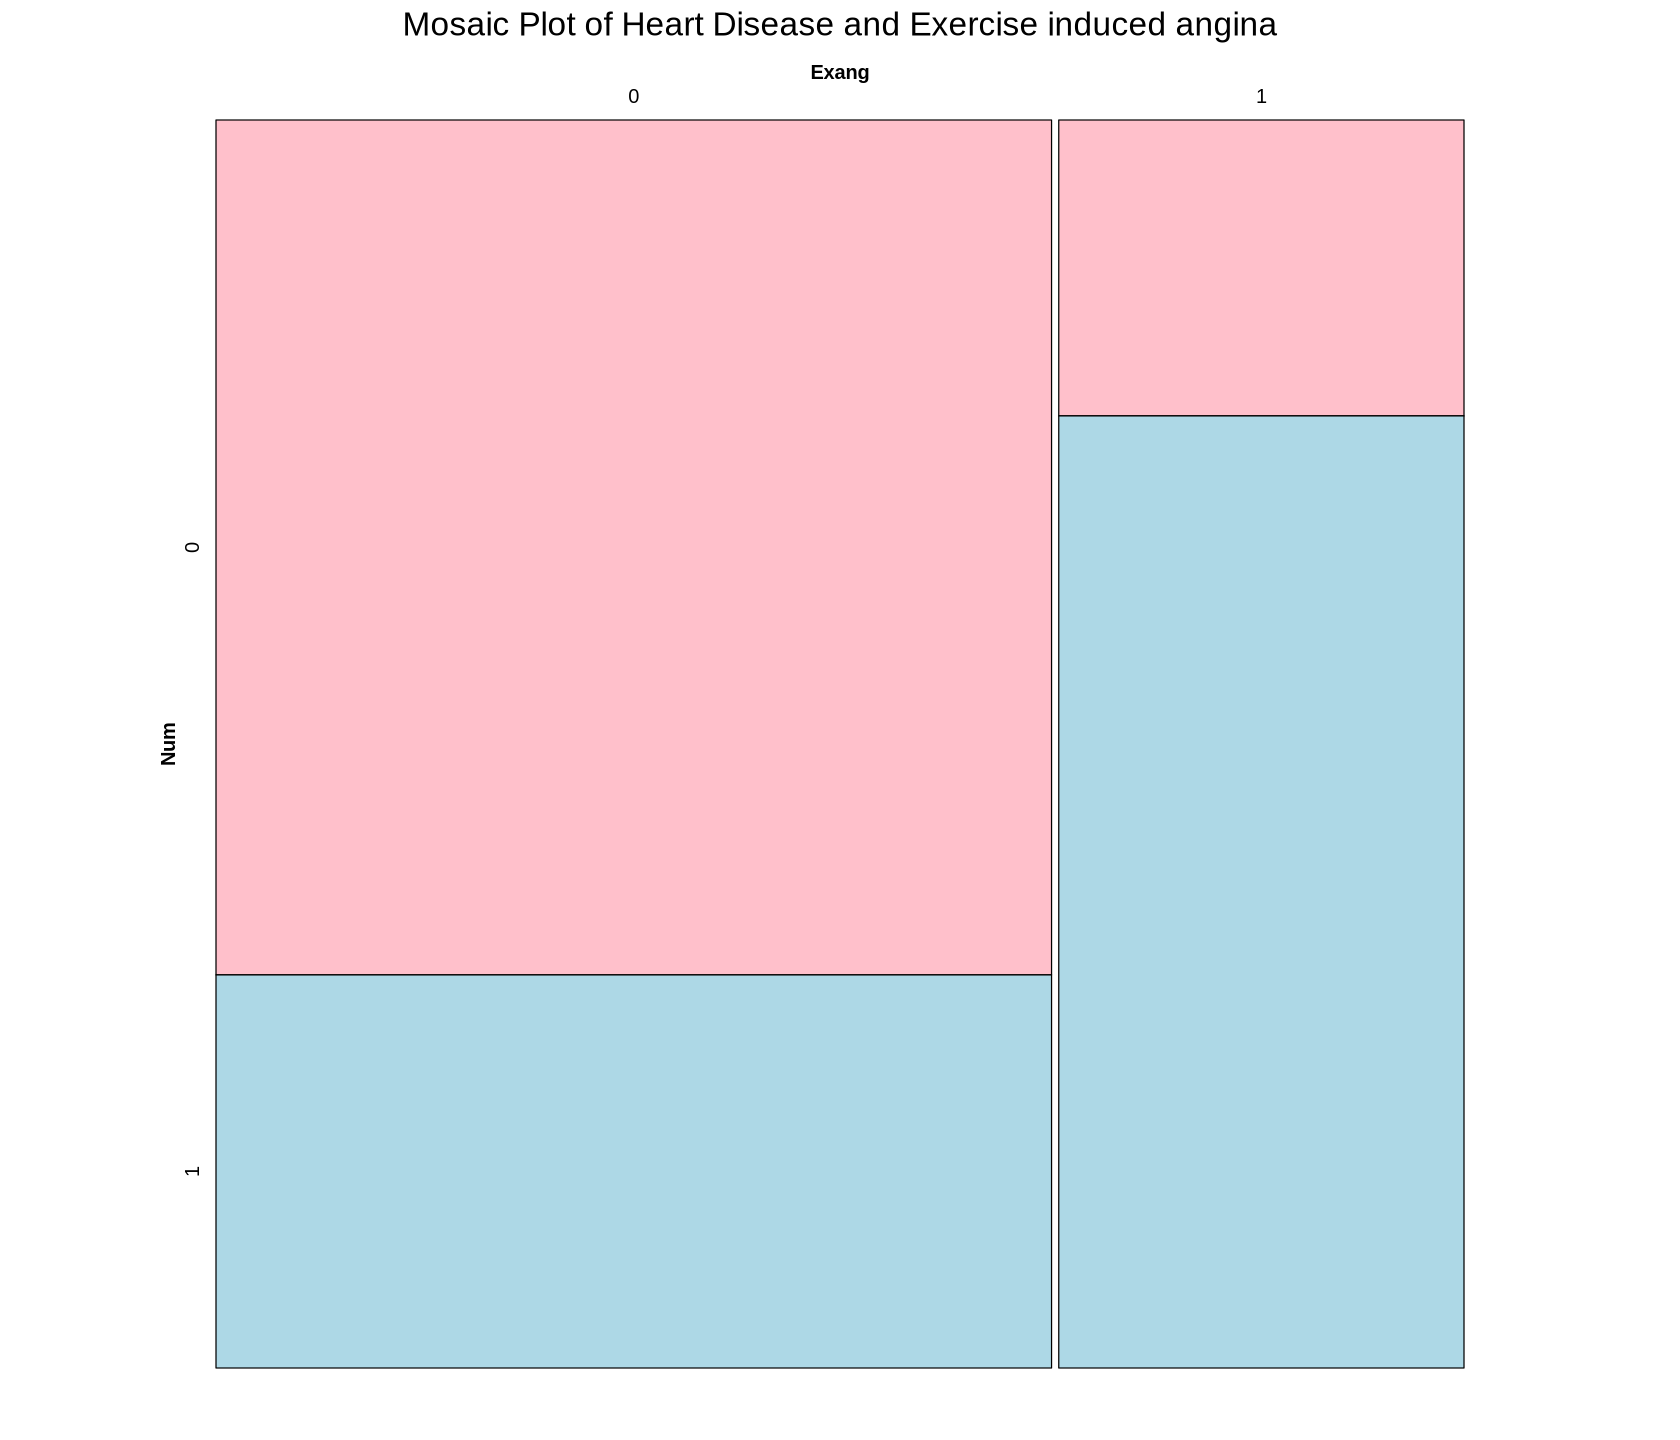

In [27]:
Mosaic_plot_Exang <- mosaic( ~ Num + Exang , data = data, highlighting = "Num", highlighting_fill = c("pink", "lightblue"), main = "Mosaic Plot of Heart Disease and Exercise induced angina")
Mosaic_plot_Exang

    Slope   1   2   3
Num                  
0         103  48   9
1          36  89  12

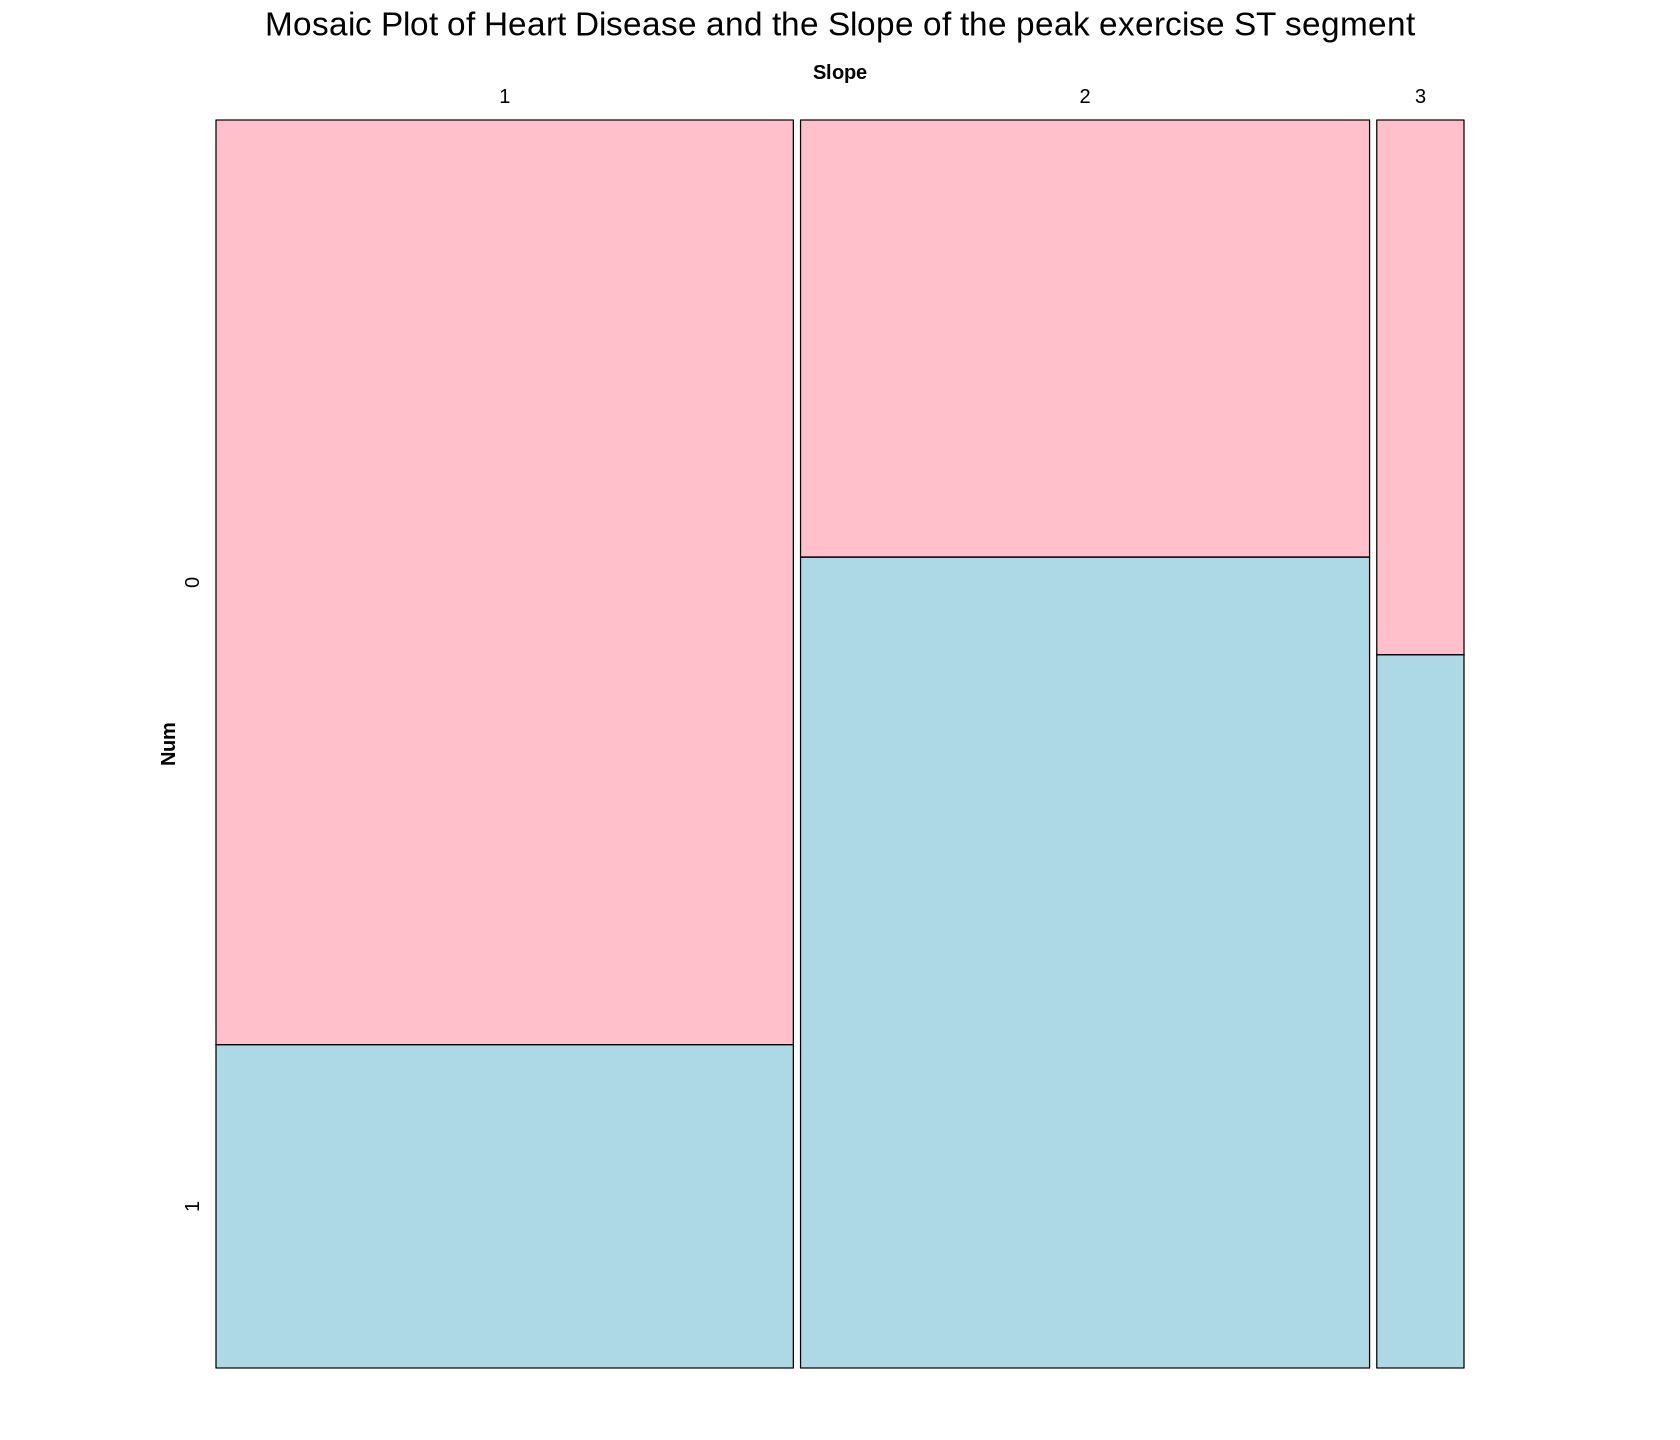

In [28]:
Mosaic_plot_Slope <- mosaic( ~ Num + Slope , data = data, highlighting = "Num", highlighting_fill = c("pink", "lightblue"), main = "Mosaic Plot of Heart Disease and the Slope of the peak exercise ST segment")
Mosaic_plot_Slope

    Thal   3   6   7
Num                 
0        127   6  27
1         37  12  88

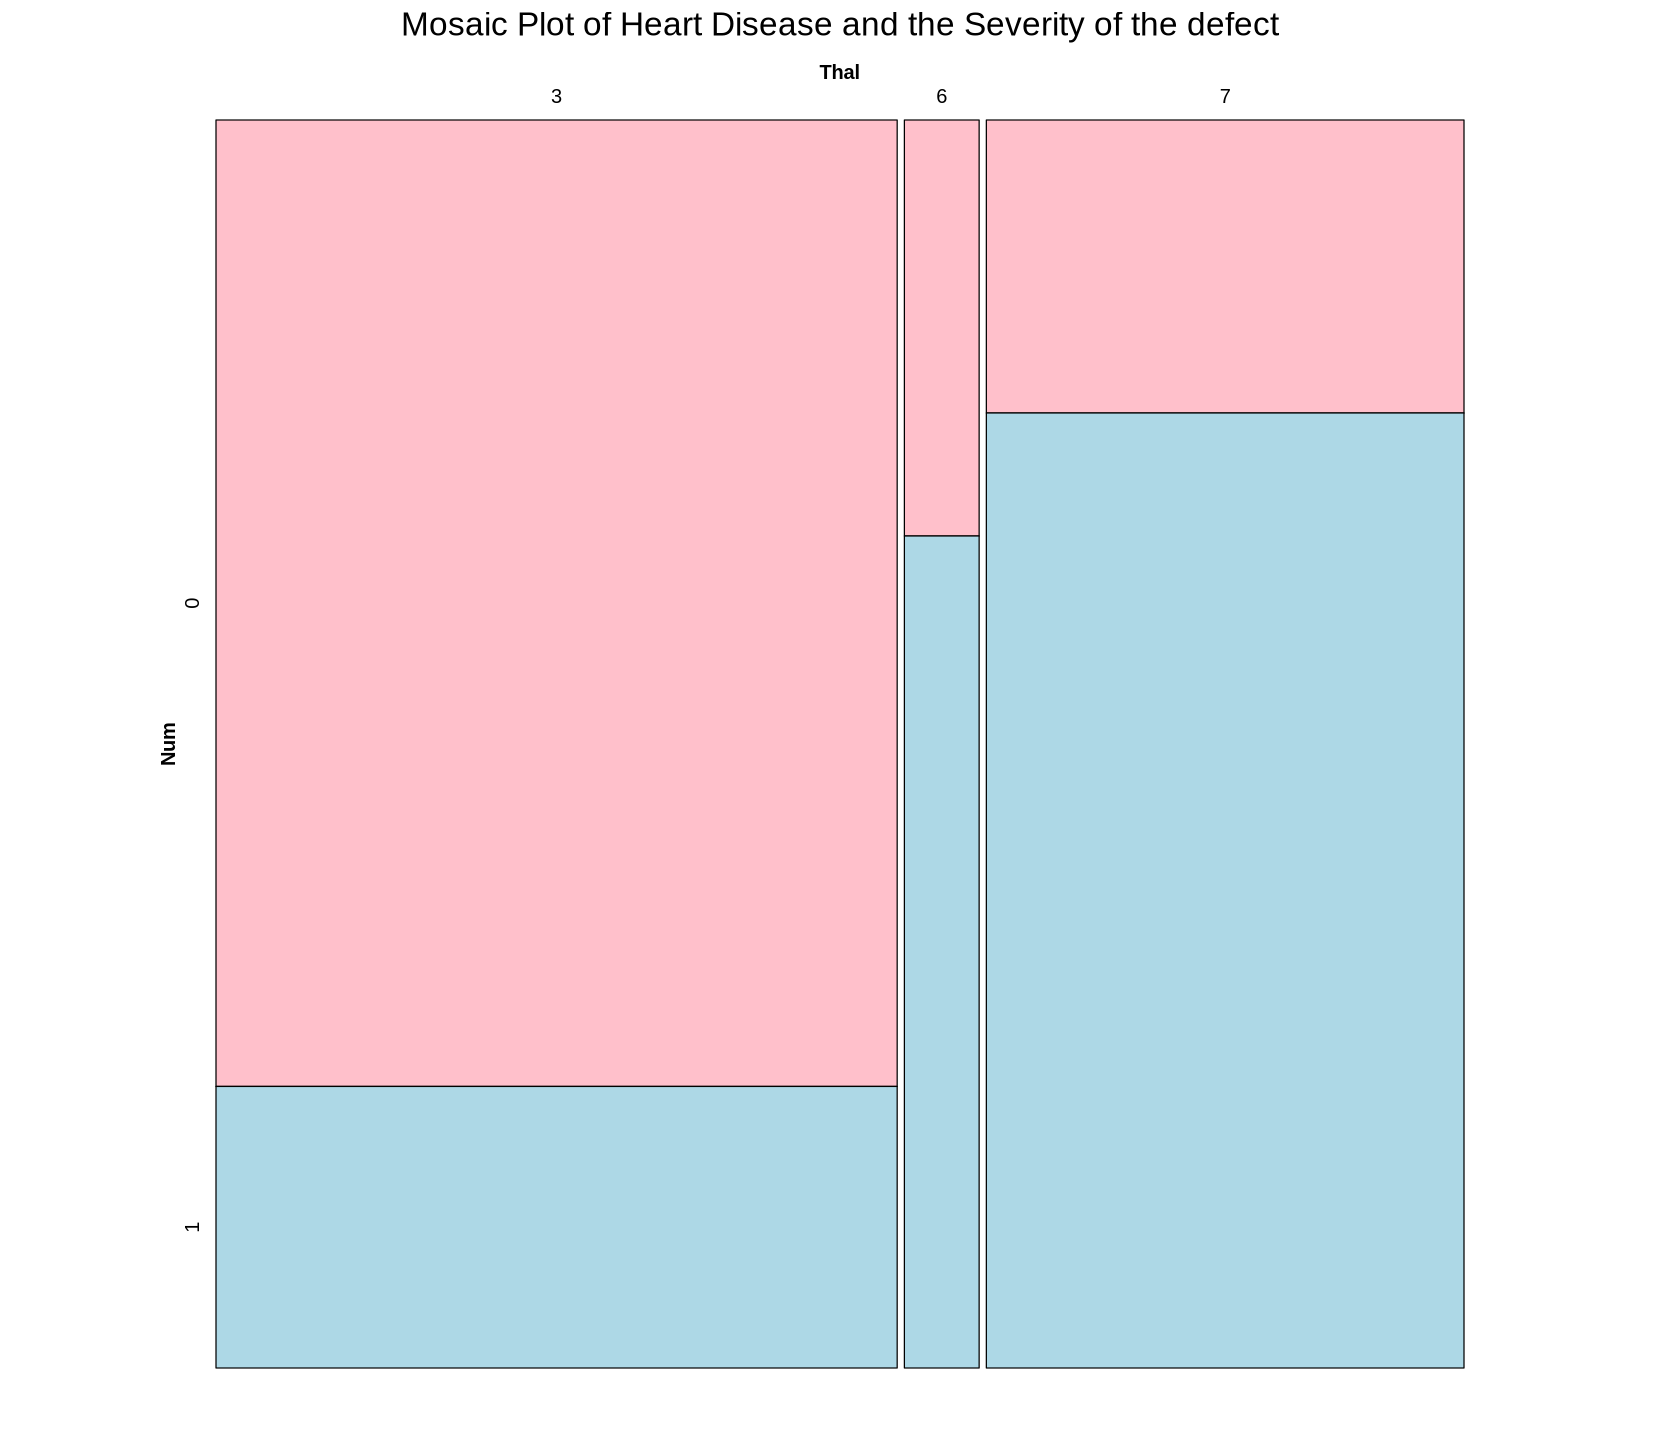

In [29]:
Mosaic_plot_Thal <- mosaic( ~ Num + Thal , data = data, highlighting = "Num", highlighting_fill = c("pink", "lightblue"), main = "Mosaic Plot of Heart Disease and the Severity of the defect")
Mosaic_plot_Thal

There is some imbalance in the groups for different catergories but not to the extreme.

 ## Method

### Baseline model

In [56]:
baseline_model <- glm(Num ~ ., data = data, family = binomial)

summary(baseline_model)


Call:
glm(formula = Num ~ ., family = binomial, data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7818  -0.5207  -0.1863   0.4248   2.3622  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -7.372042   2.879476  -2.560  0.01046 *  
Age         -0.014164   0.023970  -0.591  0.55459    
Sex          1.312073   0.488474   2.686  0.00723 ** 
Cp           0.575898   0.191197   3.012  0.00259 ** 
Trestbps     0.024044   0.010730   2.241  0.02504 *  
Chol         0.004995   0.003774   1.324  0.18561    
Fbs         -1.021918   0.555330  -1.840  0.06574 .  
Restecg      0.245153   0.185005   1.325  0.18513    
Thalach     -0.020665   0.010225  -2.021  0.04327 *  
Exang        0.926104   0.413343   2.241  0.02506 *  
Oldpeak      0.247386   0.211832   1.168  0.24287    
Slope        0.570009   0.363085   1.570  0.11644    
Ca           1.267719   0.265384   4.777 1.78e-06 ***
Thal         0.343936   0.100361   3.427  0.00061 ***

### Spliting the data

In [57]:
set.seed(4321)
heart_disease_selection <- initial_split(data, prop = 0.7, strata = Num)
heart_disease_train <- training(heart_disease_selection)
heart_disease_test <- testing(heart_disease_selection)

head(heart_disease_train)

Age Sex Cp Trestbps Chol Fbs Restecg Thalach Exang Oldpeak Slope Ca Thal Num
1 63  1   1  145      233  1   2       150     0     2.3     3     0  6    0  
2 37  1   3  130      250  0   0       187     0     3.5     3     0  3    0  
3 41  0   2  130      204  0   2       172     0     1.4     1     0  3    0  
4 56  1   2  120      236  0   0       178     0     0.8     1     0  3    0  
5 56  0   2  140      294  0   2       153     0     1.3     2     0  3    0  
6 44  1   2  120      263  0   0       173     0     0.0     1     0  7    0

### Using lasso

Splitting the training set into a design matrix and the y vector for cross validation 

In [58]:
set.seed(4321)
model_matrix_X_train <- 
    model.matrix(Num~., data = heart_disease_train)
model_matrix_X_train <- model_matrix_X_train[, -1]

matrix_Y_train <- 
    as.matrix(heart_disease_train$Num, ncol = 1)

We already prepared our training data with `model_matrix_X_train` and `matrix_Y_train`. Now we need to find the value of $\lambda$ in $L_{\text{LASSO}}(\beta_0, \beta_1, \dots, \beta_{p-1})$ that provides the largest average AUC. We are using 5 fold here for cross validation.

We assign it into `heart_disease_lambda_LASSO`

In [59]:
set.seed(4321) # do not change this!

heart_disease_lambda_LASSO <- 
  cv.glmnet(
  x = model_matrix_X_train, y = matrix_Y_train,
  alpha = 1,
  family = "binomial",
  type.measure = "auc",
  nfolds = 5)

heart_disease_lambda_LASSO


Call:  cv.glmnet(x = model_matrix_X_train, y = matrix_Y_train, type.measure = "auc",      nfolds = 5, alpha = 1, family = "binomial") 

Measure: AUC 

     Lambda Index Measure      SE Nonzero
min 0.00121    58  0.8819 0.01980      13
1se 0.08725    12  0.8644 0.02651       8

Plotting the lasso regression cross validation

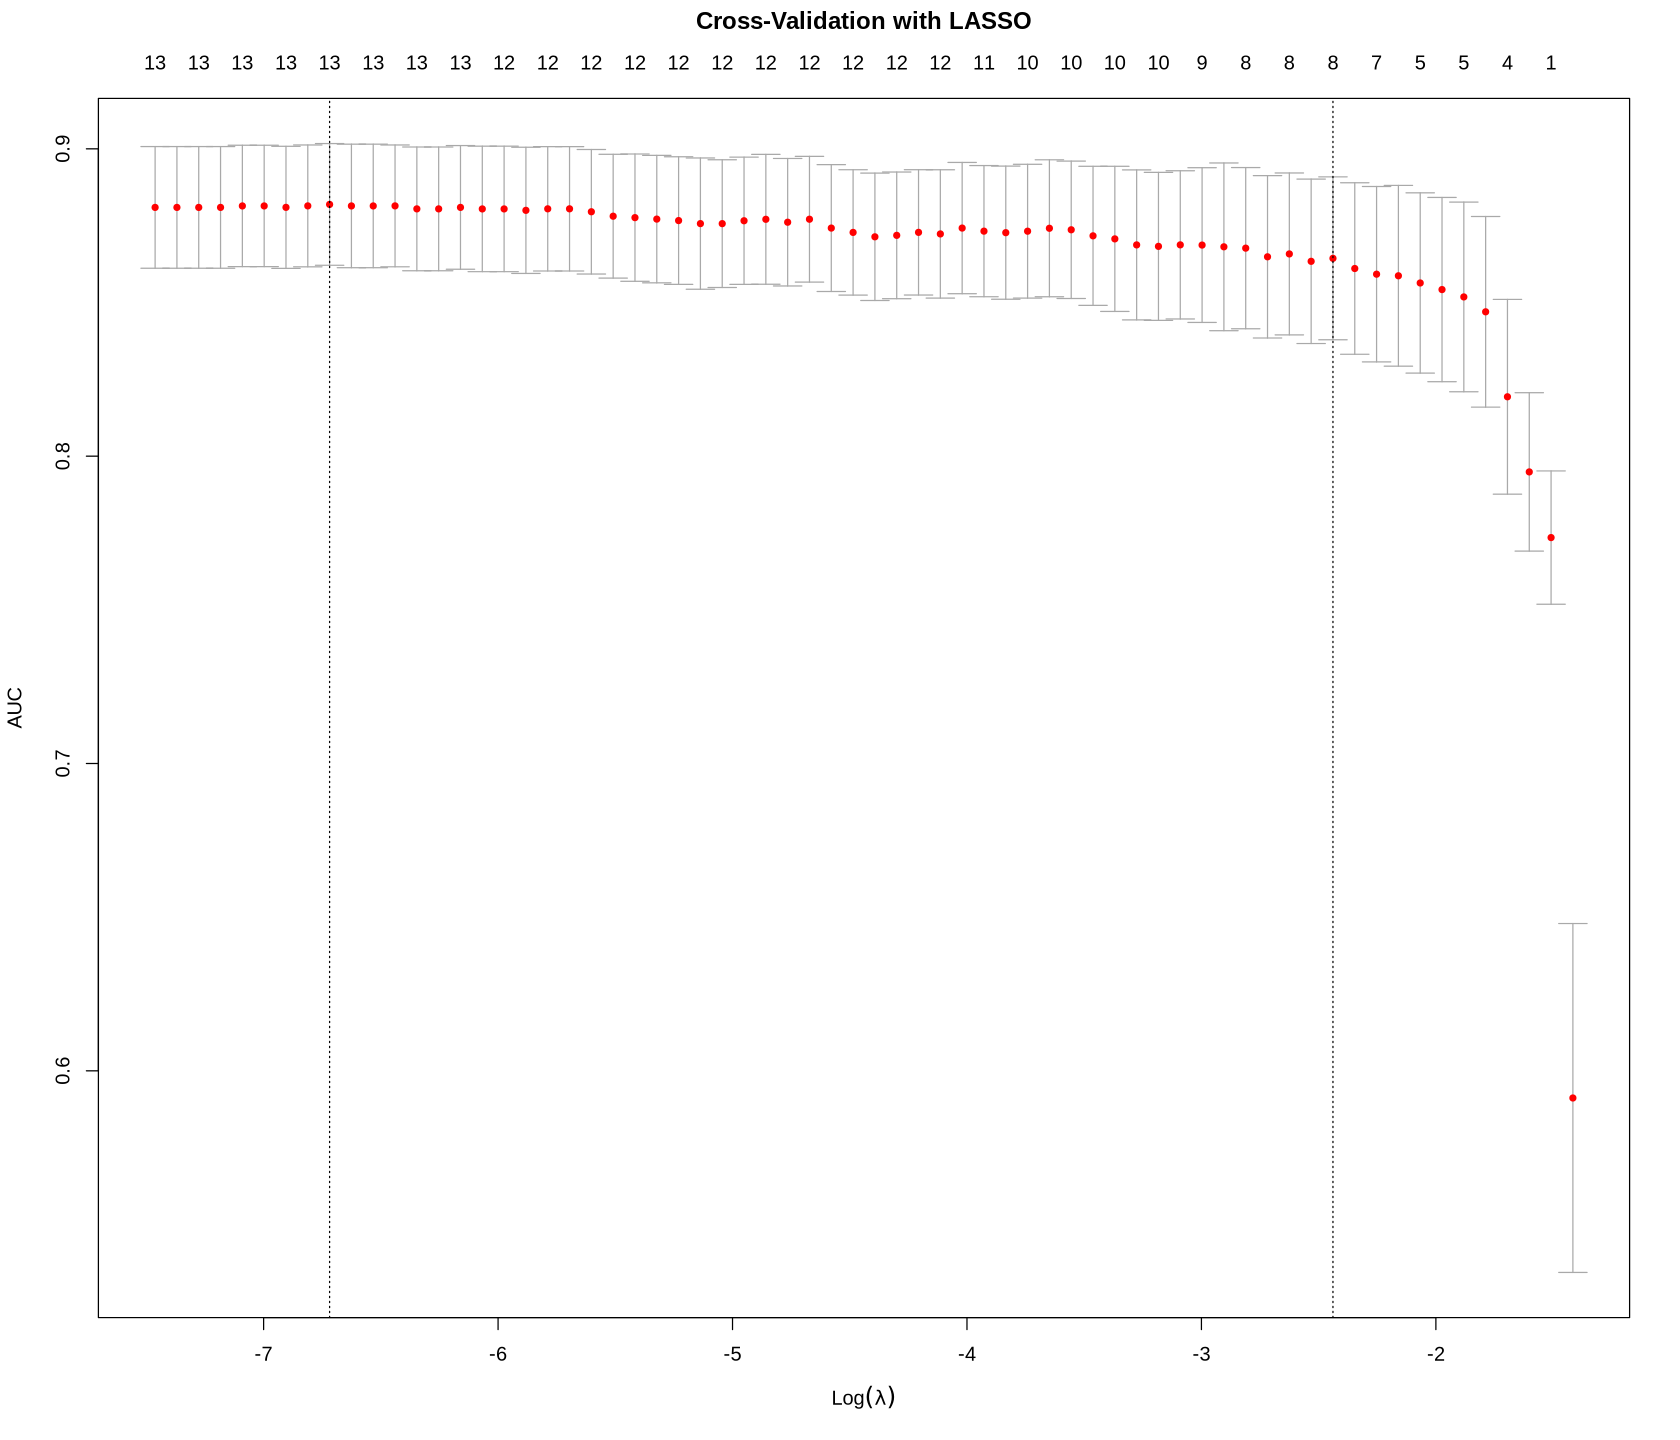

In [60]:
plot(heart_disease_lambda_LASSO, main = "Cross-Validation with LASSO\n\n")

The plot of the output coming from `cv.glmnet()` shows two vertical dotted lines. These lines correspond to two values of $\lambda$:

- $\hat{\lambda}_{\text{min}}$ which provides the maximum average AUC out of the whole sequence for $\lambda$. We can obtain it with `object$lambda.min`.


- $\hat{\lambda}_{\text{1SE}}$ is the highest $\lambda$ for which the model has an average AUC within one standard error of the maximum. We can obtain it with `object$lambda.

- $\hat{\lambda}_{\text{min}}$ is preferable in this case1se`.

In [61]:
heart_disease_lambda_min_AUC_LASSO <- round(heart_disease_lambda_LASSO$lambda.min, 4)

heart_disease_lambda_min_AUC_LASSO

[1] 0.0012

We will use the function `glmnet()` along with `model_matrix_X_train` and `matrix_Y_train`. Extract the estimated model for `lambda` equal to `heart_disease_lambda_min_AUC_LASSO`. Call the output `heart_disease_LASSO_min_AUC`.

In [62]:
set.seed(4321) 

heart_disease_LASSO_min_AUC <- glmnet(
  x = model_matrix_X_train, y = matrix_Y_train,
  alpha = 1,
  family = "binomial",
  lambda = heart_disease_lambda_min_AUC_LASSO
)


coef(heart_disease_LASSO_min_AUC)

14 x 1 sparse Matrix of class "dgCMatrix"
                      s0
(Intercept) -6.697356591
Age         -0.003254081
Sex          1.493241989
Cp           0.660284388
Trestbps     0.023482581
Chol         0.003883784
Fbs         -0.622331713
Restecg      0.178857397
Thalach     -0.024219195
Exang        0.691405693
Oldpeak      0.085105835
Slope        0.615027962
Ca           1.007756356
Thal         0.226362549

Now we axtract the AUC to compare them later

In [63]:
best_auc_lasso <- heart_disease_lambda_LASSO$cvm[which(heart_disease_lambda_LASSO$lambda == heart_disease_lambda_LASSO$lambda.min)]

best_auc_lasso

[1] 0.8819176

### Using Ridge

As for Ridge we are using 10 fold for cross validation

In [64]:
set.seed(4321) # do not change this!

heart_disease_lambda_Ridge <- 
  cv.glmnet(
  x = model_matrix_X_train, y = matrix_Y_train,
  alpha = 0,
  family = "binomial",
  type.measure = "auc",
  nfolds = 10)

heart_disease_lambda_Ridge


Call:  cv.glmnet(x = model_matrix_X_train, y = matrix_Y_train, type.measure = "auc",      nfolds = 10, alpha = 0, family = "binomial") 

Measure: AUC 

    Lambda Index Measure      SE Nonzero
min  221.2     2  0.8898 0.01762      13
1se  221.2     2  0.8898 0.01762      13

Plotting the Ridge regression cross validation

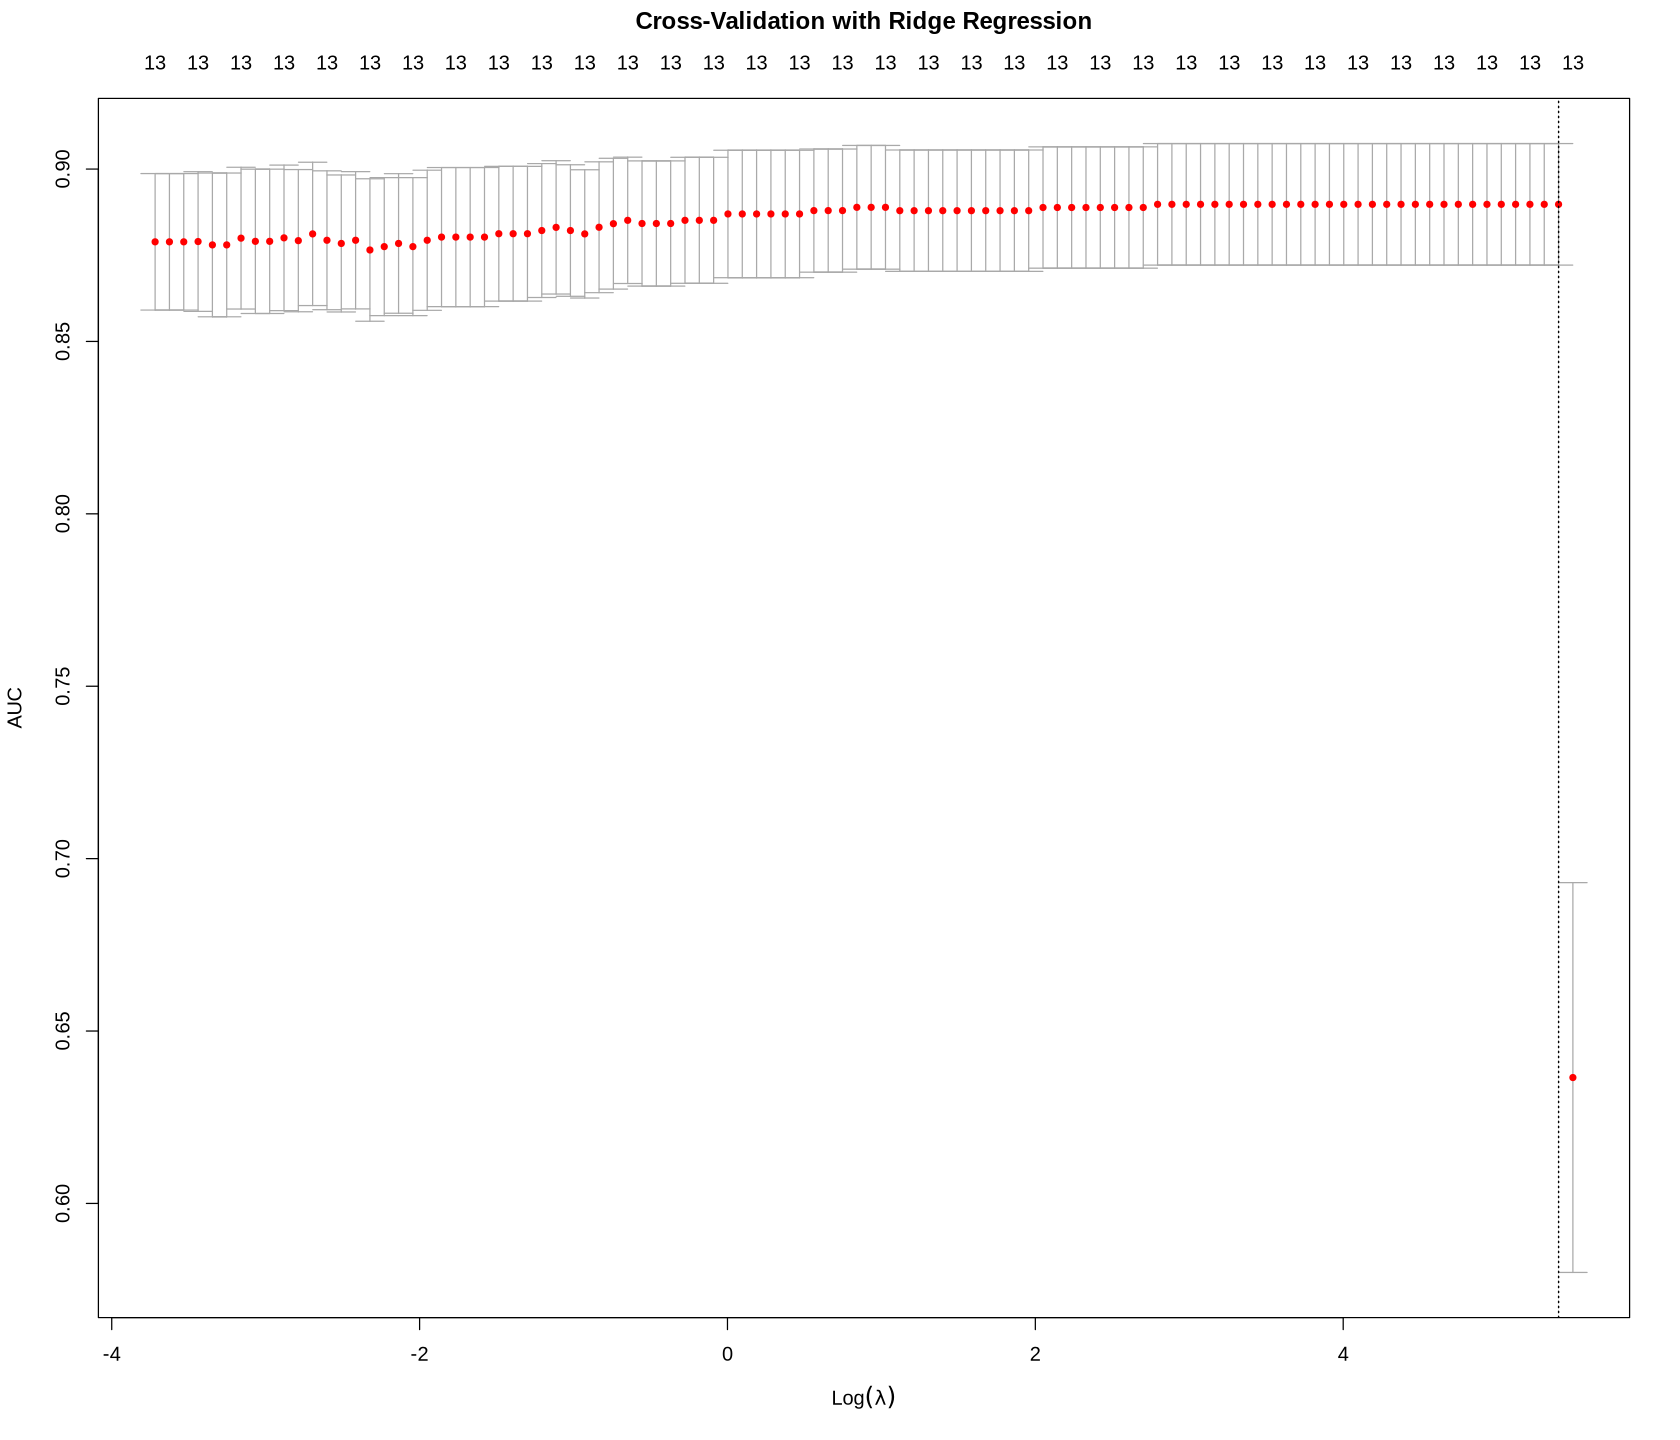

In [65]:
plot(heart_disease_lambda_Ridge, 
     main = "Cross-Validation with Ridge Regression\n\n")

Using `heart_disease_lambda_Ridge`, obtain $\hat{\lambda}_{\text{min}}$ and assign it to the variable `heart_disease_lambda_max_AUC_ridge`.

In [66]:
heart_disease_lambda_max_AUC_ridge <- round(heart_disease_lambda_Ridge$lambda.min, 4)

heart_disease_lambda_max_AUC_ridge

[1] 221.2059

Now that we have to the optimal value, we will fit the ridge regression model

In [67]:
set.seed(4321) 

heart_disease_ridge_max_AUC <- 
  glmnet(
  x = model_matrix_X_train, y = matrix_Y_train,
  alpha = 0,
  family = "binomial",
  lambda = heart_disease_lambda_max_AUC_ridge
)


coef(heart_disease_ridge_max_AUC)

14 x 1 sparse Matrix of class "dgCMatrix"
                       s0
(Intercept) -1.766296e-01
Age          6.047808e-05
Sex          1.374983e-03
Cp           1.007764e-03
Trestbps     2.040284e-05
Chol         3.258611e-06
Fbs          2.128619e-04
Restecg      3.993531e-04
Thalach     -4.149086e-05
Exang        1.875312e-03
Oldpeak      7.014824e-04
Slope        1.261509e-03
Ca           1.062711e-03
Thal         5.673136e-04

Now we also extract AUC to compare 

In [68]:
best_auc_ridge <- heart_disease_lambda_Ridge$cvm[which(heart_disease_lambda_Ridge$lambda == heart_disease_lambda_Ridge$lambda.min)]

best_auc_ridge

[1] 0.8897736

### CV-AUC for the baseline model

In [76]:
set.seed(4321)
num.folds <- 10

folds <- createFolds(heart_disease_train$Num, k=num.folds)

regr.cv <- NULL
for (fold in 1:num.folds) {
train.idx <- setdiff(1:nrow(heart_disease_train), folds[[fold]])
regr.cv[[fold]] <- glm(Num ~ ., data=heart_disease_train, subset=train.idx,
                       family="binomial")
    }

pred.cv <- NULL
auc.cv <- numeric(num.folds) 

for (fold in 1:num.folds) {
test.idx <- folds[[fold]]
pred.cv[[fold]] <- data.frame(obs=heart_disease_train$Num[test.idx],
pred=predict(regr.cv[[fold]], newdata=heart_disease_train, type="response")[test.idx])
auc.cv[fold] <- roc(obs ~ pred, data=pred.cv[[fold]])$auc
    }

heart_disease_cv_baseline <- round(mean(auc.cv),7)

cat("Cross-validation AUC for the baseline logistic model:", 
heart_disease_cv_baseline)

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Cross-validation AUC for the baseline logistic model: 0.8767728

### Forward selection

In [70]:
set.seed(4321)

# Perform forward selection using regsubsets
regfit_fwd <- regsubsets(Num ~ ., data = heart_disease_train, nvmax = NULL, method = "forward")

# Summary of the model
reg_summary <- summary(regfit_fwd)

# Get the model with the lowest BIC
best_model <- which.min(reg_summary$bic)
best_model

# Extract the selected predictors
selected_predictors <- names(coef(regfit_fwd, best_model))
selected_predictors <- selected_predictors[-1]  # Remove intercept
selected_predictors

[1] 6

[1] "Sex"   "Cp"    "Exang" "Slope" "Ca"    "Thal"

Now we have the best performing predictors from forward selection, we use cross validation to see the AUC

In [71]:

set.seed(4321)
num.folds <- 10

folds <- createFolds(heart_disease_train$Num, k=num.folds)

regr.cv <- NULL
for (fold in 1:num.folds) {
train.idx <- setdiff(1:nrow(heart_disease_train), folds[[fold]])
regr.cv[[fold]] <- glm(Num ~ Sex+Cp+ Exang+ Slope+ Ca+ Thal, data=heart_disease_train, subset=train.idx,
                       family="binomial")
    }

pred.cv <- NULL
auc.cv <- numeric(num.folds) 

for (fold in 1:num.folds) {
test.idx <- folds[[fold]]
pred.cv[[fold]] <- data.frame(obs=heart_disease_train$Num[test.idx],
pred=predict(regr.cv[[fold]], newdata=heart_disease_train, type="response")[test.idx])
auc.cv[fold] <- roc(obs ~ pred, data=pred.cv[[fold]])$auc
    }

heart_disease_cv_forward <- round(mean(auc.cv),7)

cat("Cross-validation AUC for the forward selection logistic model:", 
heart_disease_cv_forward)

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Cross-validation AUC for the forward selection logistic model: 0.8871298

### Comparison of the AUC for the model selection

In [72]:
heart_disease_AUC_models <- 
    tibble(
        model = c("baseline", "ridge", "lasso", "forward"),
        auc = c(heart_disease_cv_baseline,best_auc_ridge, best_auc_lasso, heart_disease_cv_forward))

heart_disease_AUC_models

model    auc      
1 baseline 0.8767728
2 ridge    0.8897736
3 lasso    0.8819176
4 forward  0.8871298

As shown above in the table, it seems that Ridge have the highest AUC in all the methods, we will be using Ridge for the test set evaluation 

### Test set evaluation

Use the model to predict the `Num` variable on the **test** set (`heart_disease_test`). Then, use the `roc` function to obtain the ROC curve in the test set. Save the result in an object named ROC_RIDGE. 

In [73]:
set.seed(4321)
model_matrix_X_test <- 
    model.matrix(Num ~ ., data = heart_disease_test)[, -1]

ROC_RIDGE <- 
    roc(
        response = heart_disease_test$Num,
        predictor = predict(heart_disease_ridge_max_AUC,
                     newx = model_matrix_X_test)[,"s0"] ) 


ROC_RIDGE

Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = heart_disease_test$Num, predictor = predict(heart_disease_ridge_max_AUC,     newx = model_matrix_X_test)[, "s0"])

Data: predict(heart_disease_ridge_max_AUC, newx = model_matrix_X_test)[, "s0"] in 48 controls (heart_disease_test$Num 0) < 42 cases (heart_disease_test$Num 1).
Area under the curve: 0.9345

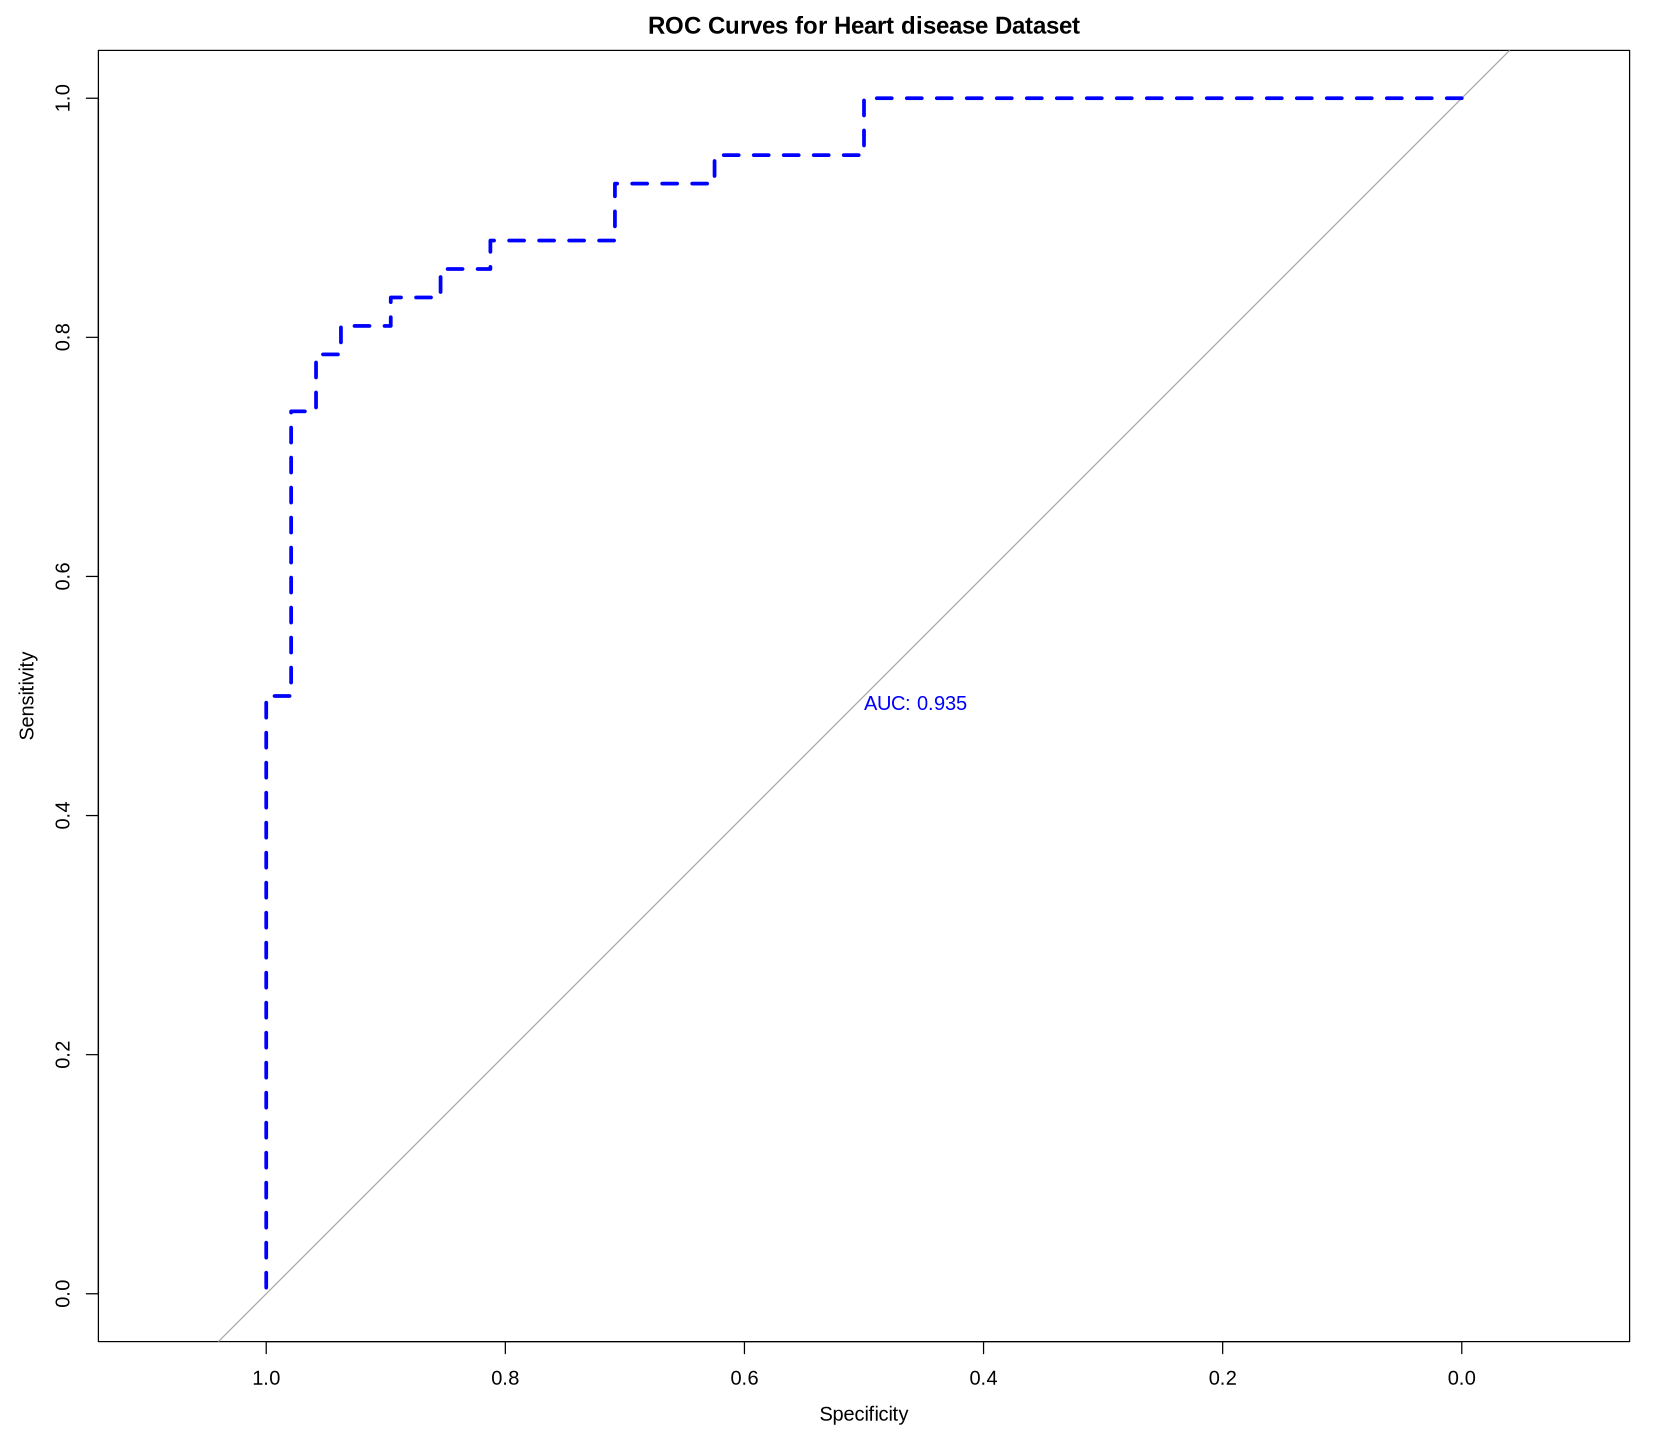

In [74]:
plot(ROC_RIDGE,
  print.auc = TRUE, col = "blue", lwd = 3, lty = 2,
  main = "ROC Curves for Heart disease Dataset"
)

# Discussion

### Summary of Findings


In this analysis, we evaluated several logistic regression models to predict heart disease using various regularization techniques and model selection methods. The models and their respective cross-validated AUC (Area Under the Curve) scores on the training data are as follows:

 - **Baseline Logistic Regression Model**: 0.8767728
 - **Ridge Regression Model**: 0.8897736
 - **LASSO Regression Model**: 0.8819176
 - **Forward Selection Model**: 0.8871298
 
 
 When evaluating the best-performing model, the **Ridge Regression Model**, on the test set, we obtained an AUC of 0.9345.

**Expectation:** We expected the Ridge model to overfit as but suprisingly, it is the best performing model of all the models, though the test set evaluation have higher value than the the training set, it is not a significant difference, this could be explained by a low number of observation in the dataset

**Inprovement of the model** 
 
 - A way we could improve the model is by training on a larger dataset, since the number of observation is low, there could be a lot of biased from the data. 
 - We could also consider using tree based model in machine learning since they are more fitted to do classification than linear models

**Future research:**

**Comparison with Other Algorithms:**

 - Comparing the performance of logistic regression models with other machine learning algorithms like Random Forest, Gradient Boosting, or Neural Networks could provide a broader perspective on the best approach for this problem.
 
 
**External Validation:**

 - Validate the model on external datasets from different populations to assess its generalizability and robustness.

# Reference

**References (APA)**

Hammad, M., Maher, A., Wang, K., Jiang, F., & Amrani, M. (2018). Detection of abnormal heart conditions based on characteristics of ECG signals. Measurement 125(634–644). https://doi.org/10.1016/j.measurement.2018.05.033

Ohio Department of Health. (2016). Ohio 2016 BRFSS Annual Report. Retrieved from https://odh.ohio.gov/know-our-programs/chronic-disease/data-publications/ohio-2016-brfss-annual-report 

Schwartz, F., Ruhil, A., Denham, S., Shubrook, J., Simpson, C., & Boyd, S. L. (2009). High self‐reported prevalence of diabetes mellitus, heart disease, and stroke in 11 counties of rural Appalachian Ohio. The Journal of Rural Health, 25(2). https://doi.org/10.1111/j.1748-0361.2009.00222.x
